## Notebook to visualize colocalization results as a heatmap

In [1]:
!date

Thu Oct 12 20:56:36 UTC 2023


#### import libraries

In [2]:
from pandas import read_csv, concat, pivot, read_pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from seaborn import heatmap
from os.path import exists
from math import ceil
import numpy as np

%matplotlib inline
# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

#### set notebook variables

In [3]:
# naming
cohort = 'foundin'
dx = 'PD'

# directories
wrk_dir = '/home/jupyter/foundin_qtl'
results_dir = f'{wrk_dir}/results'
figures_dir = f'{wrk_dir}/figures'
quants_dir = f'{wrk_dir}/quants'
public_dir = f'{wrk_dir}/public'

# in file
rnab_features_file = f'{public_dir}/gencode_v29.lncipedia_v5_2_hc.annotation.pkl'
pdui_features_file = f'{quants_dir}/{cohort}_PDUI.features.csv'

# out files
figure_file = f'{figures_dir}/{cohort}.colocalization.{dx}.png'

# variables
DEBUG = False
days = ['da0', 'da25', 'da65', 'daNA', 'D52']
# modalities = ['ATAC', 'METH', 'PDUI', 'RNAB', 'RNAS', 'CIRC', 'SCRN-DA', 'SCRN-ElC', 
#               'SCRN-eNP', 'SCRN-iDA', 'SCRN-lNP', 'SCRN-NlC', 'SCRN-PFPP']
modalities = ['PDUI', 'RNAB', 'RNAS', 'CIRC', 'SCRN-DA', 'SCRN-ElC', 
              'SCRN-eNP', 'SCRN-iDA', 'SCRN-lNP', 'SCRN-NlC', 'SCRN-PFPP', 
              'PDUI-DA', 'PDUI-iDA',
              'Bryois-Astro', 'Bryois-Endo', 'Bryois-ExN', 'Bryois-InN', 
              'Bryois-Micro', 'Bryois-OPC', 'Bryois-Oligo', 'Bryois-Peri', 
              'Bulk-meta', 'DAn-meta', 'MetaBrain-basalganglia', 
              'MetaBrain-cerebellum', 'MetaBrain-cortex', 
              'MetaBrain-hippocampus', 'MetaBrain-spinalcord', 
              'hipsci-DA', 'hipsci-pseudobulk']
dpi_value = 100
min_h4 = 0.5

### for each day and modality load the colocalization results

In [4]:
coloc_df = None
for day in days:
    for modality in modalities:
        print(day, modality, end=':')
        in_file = f'{results_dir}/{cohort}_{day}_{modality}_{dx}.coloc.pp.csv'
        if exists(in_file):
            this_df = read_csv(in_file)
            print(f'loaded {this_df.shape[0]} results')
            # add day and modality
            this_df['day'] = day
            this_df['modality'] = modality
            coloc_df = concat([coloc_df, this_df])
print(f'\ntotal results loaded {coloc_df.shape[0]}')
if DEBUG:
    display(coloc_df.sample(5))
    display(coloc_df.day.value_counts())
    display(coloc_df.modality.value_counts())        

da0 PDUI:loaded 59 results
da0 RNAB:loaded 53 results
da0 RNAS:loaded 1 results
da0 CIRC:da0 SCRN-DA:da0 SCRN-ElC:da0 SCRN-eNP:da0 SCRN-iDA:da0 SCRN-lNP:da0 SCRN-NlC:da0 SCRN-PFPP:da0 PDUI-DA:da0 PDUI-iDA:da0 Bryois-Astro:da0 Bryois-Endo:da0 Bryois-ExN:da0 Bryois-InN:da0 Bryois-Micro:da0 Bryois-OPC:da0 Bryois-Oligo:da0 Bryois-Peri:da0 Bulk-meta:da0 DAn-meta:da0 MetaBrain-basalganglia:da0 MetaBrain-cerebellum:da0 MetaBrain-cortex:da0 MetaBrain-hippocampus:da0 MetaBrain-spinalcord:da0 hipsci-DA:da0 hipsci-pseudobulk:da25 PDUI:loaded 55 results
da25 RNAB:loaded 48 results
da25 RNAS:loaded 3 results
da25 CIRC:loaded 2 results
da25 SCRN-DA:da25 SCRN-ElC:da25 SCRN-eNP:da25 SCRN-iDA:da25 SCRN-lNP:da25 SCRN-NlC:da25 SCRN-PFPP:da25 PDUI-DA:da25 PDUI-iDA:da25 Bryois-Astro:da25 Bryois-Endo:da25 Bryois-ExN:da25 Bryois-InN:da25 Bryois-Micro:da25 Bryois-OPC:da25 Bryois-Oligo:da25 Bryois-Peri:da25 Bulk-meta:da25 DAn-meta:da25 MetaBrain-basalganglia:da25 MetaBrain-cerebellum:da25 MetaBrain-cortex:da25

### load needed feature information

#### load RNAB features
RNAB features use Ensembl IDs need to map to gene names

In [5]:
%%time
annots_df = read_pickle(rnab_features_file)
print(f'annotations shape: {annots_df.shape}')

if DEBUG:
    display(annots_df.head())

annotations shape: (3072652, 50)
CPU times: user 6.65 s, sys: 3.19 s, total: 9.84 s
Wall time: 9.83 s


##### deference feature IDs to features names

In [6]:
feature_annots = annots_df.loc[annots_df.gene_id.isin(coloc_df.feature)].copy()
feature_annots = feature_annots[['gene_id', 'gene_name']]
feature_annots = feature_annots.drop_duplicates()
features_dict = feature_annots.set_index('gene_id').to_dict()['gene_name']
if DEBUG:
    display(features_dict)

#### replace the RNAB features

In [7]:
coloc_df.feature.replace(features_dict, inplace=True)
print(f'update df shape {coloc_df.shape}')
if DEBUG:
    display(coloc_df.loc[coloc_df.modality == 'RNAB'].head())

update df shape (1494, 9)


### replace the HipSci DA and pseudobulk features
they used unversioned Ensembl IDs

In [8]:
annots_df.columns

Index(['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand',
       'frame', 'ID', 'ccdsid', 'exon_id', 'exon_number', 'gene_alias_1',
       'gene_alias_10', 'gene_alias_11', 'gene_alias_12', 'gene_alias_13',
       'gene_alias_14', 'gene_alias_15', 'gene_alias_16', 'gene_alias_2',
       'gene_alias_3', 'gene_alias_4', 'gene_alias_5', 'gene_alias_6',
       'gene_alias_7', 'gene_alias_8', 'gene_alias_9', 'gene_id', 'gene_name',
       'gene_type', 'havana_gene', 'havana_transcript', 'level', 'ont',
       'protein_id', 'tag', 'transcript_alias_1', 'transcript_alias_2',
       'transcript_alias_3', 'transcript_alias_4', 'transcript_alias_5',
       'transcript_alias_6', 'transcript_alias_7', 'transcript_alias_8',
       'transcript_alias_9', 'transcript_id', 'transcript_name',
       'transcript_support_level', 'transcript_type'],
      dtype='object')

In [9]:
temp_df = annots_df.gene_id.str.split('.', expand=True)
annots_df['other_gene_id'] = temp_df[0]
feature_annots = annots_df.loc[annots_df.other_gene_id.isin(coloc_df.feature)].copy()
features_dict = feature_annots.set_index('other_gene_id').to_dict()['gene_name']
coloc_df.feature.replace(features_dict, inplace=True)
print(f'update df shape {coloc_df.shape}')
if DEBUG:
    display(features_dict)
    display(coloc_df.loc[coloc_df.modality == 'hipsci-DA'].head())    

update df shape (1494, 9)


#### load PDUI features

In [10]:
%%time
annots_df = read_csv(pdui_features_file)
print(f'annotations shape: {annots_df.shape}')

if DEBUG:
    display(annots_df.head())

annotations shape: (58921, 7)
CPU times: user 642 ms, sys: 8.43 ms, total: 651 ms
Wall time: 647 ms


##### deference feature IDs to features names

In [11]:
feature_annots = annots_df.loc[annots_df.Loci.isin(coloc_df.feature)]
feature_annots = feature_annots[['Loci', 'Gene']]
# some genes have multiple PDUI features, append to handle
multi_features = feature_annots.duplicated(subset=['Gene'], keep=False)
feature_annots.loc[multi_features, 'Gene'] = feature_annots.Gene + ':' + feature_annots.Loci
# feature_annots.drop_duplicates(inplace=True)
features_dict = feature_annots.set_index('Loci').to_dict()['Gene']
if DEBUG:
    display(features_dict)

#### replace the PDUI features

In [12]:
coloc_df.feature.replace(features_dict, inplace=True)
print(f'update df shape {coloc_df.shape}')
if DEBUG:
    display(coloc_df.loc[coloc_df.modality == 'PDUI'].head())

update df shape (1494, 9)


### subset based on the minimum H4 variable

In [13]:
temp = coloc_df.loc[coloc_df.H4 > min_h4]
print(f'{temp.feature.nunique()} traits will be used')
coloc_df = coloc_df.loc[coloc_df.feature.isin(temp.feature)]
print(f'results shape after filter on H4 {coloc_df.shape}')
if DEBUG:
    display(coloc_df.head())

160 traits will be used
results shape after filter on H4 (681, 9)


### reshape the dataframe from long to wide

In [14]:
# drop the cols we don't need
temp_df = coloc_df.drop(columns=['H0', 'H1', 'H2', 'H3', 'h4_supported'])
# sort not sure if this will help may have to set order in plotting explicityly
temp_df = temp_df.sort_values(by=['modality', 'day'])
# want day/modality combo's so combine
temp_df['day_modality'] = temp_df.day + '-' + temp_df.modality
# wcoloc_df = pivot(temp_df, index='feature', columns='day_modality', values='H4')
wcoloc_df = pivot(temp_df, index='feature', columns=['day', 'modality'], values='H4')
# set precision
wcoloc_df = wcoloc_df.round(2)
#replace all zeros with NaN values
wcoloc_df.replace(0, np.nan, inplace=True)
# drop rows that are all null
wcoloc_df.dropna(how='all', inplace=True)
# # sort by foundin DA neuron results
# wcoloc_df = wcoloc_df.sort_values(by=[('daNA', 'DAn-meta'), ('da65', 'SCRN-DA'), 
#                                       ('da65', 'SCRN-iDA'), 
#                                       ('daNA', 'Bulk-meta'), ('da65', 'RNAB'), 
#                                       ('da65', 'PDUI'),
#                                       ('daNA', 'Bryois-ExN'), ('daNA', 'Bryois-InN'), 
#                                       ('daNA', 'Bryois-Micro'), ('daNA', 'Bryois-Astro'), 
#                                       ('daNA', 'Bryois-Oligo')], ascending=False)
print(f'shape of wide reformated results {wcoloc_df.shape}')
if DEBUG:
    display(wcoloc_df)

shape of wide reformated results (160, 32)


### visualize the reformated data as a heatmap

In [15]:
out_col_order = [
    ('daNA', 'Bryois-Astro'), ('daNA', 'Bryois-Endo'), 
    ('daNA', 'Bryois-ExN'), ('daNA', 'Bryois-InN'), 
    ('daNA', 'Bryois-Micro'), ('daNA', 'Bryois-OPC'),
    ('daNA', 'Bryois-Oligo'), ('daNA', 'Bryois-Peri'),    
    ('daNA', 'MetaBrain-basalganglia'), 
    ('daNA', 'MetaBrain-cerebellum'), ('daNA', 'MetaBrain-cortex'), 
    ('daNA', 'MetaBrain-hippocampus'), ('daNA', 'MetaBrain-spinalcord'), 
    ('D52', 'hipsci-pseudobulk'), ('D52', 'hipsci-DA'),
    ('daNA', 'Bulk-meta'), ('daNA', 'DAn-meta'), 
    ('da65', 'SCRN-DA'), ('da65', 'SCRN-ElC'), ('da65', 'SCRN-NlC'),
    ('da65', 'SCRN-PFPP'), ('da65', 'SCRN-eNP'), ('da65', 'SCRN-iDA'), 
    ('da65', 'SCRN-lNP'), ('da65', 'CIRC'), ('da65', 'PDUI-DA'),
    ('da0', 'PDUI'), ('da25', 'PDUI'), ('da65', 'PDUI'),
    ( 'da0', 'RNAB'), ('da25', 'RNAB'), ('da65', 'RNAB')
]

PD 36


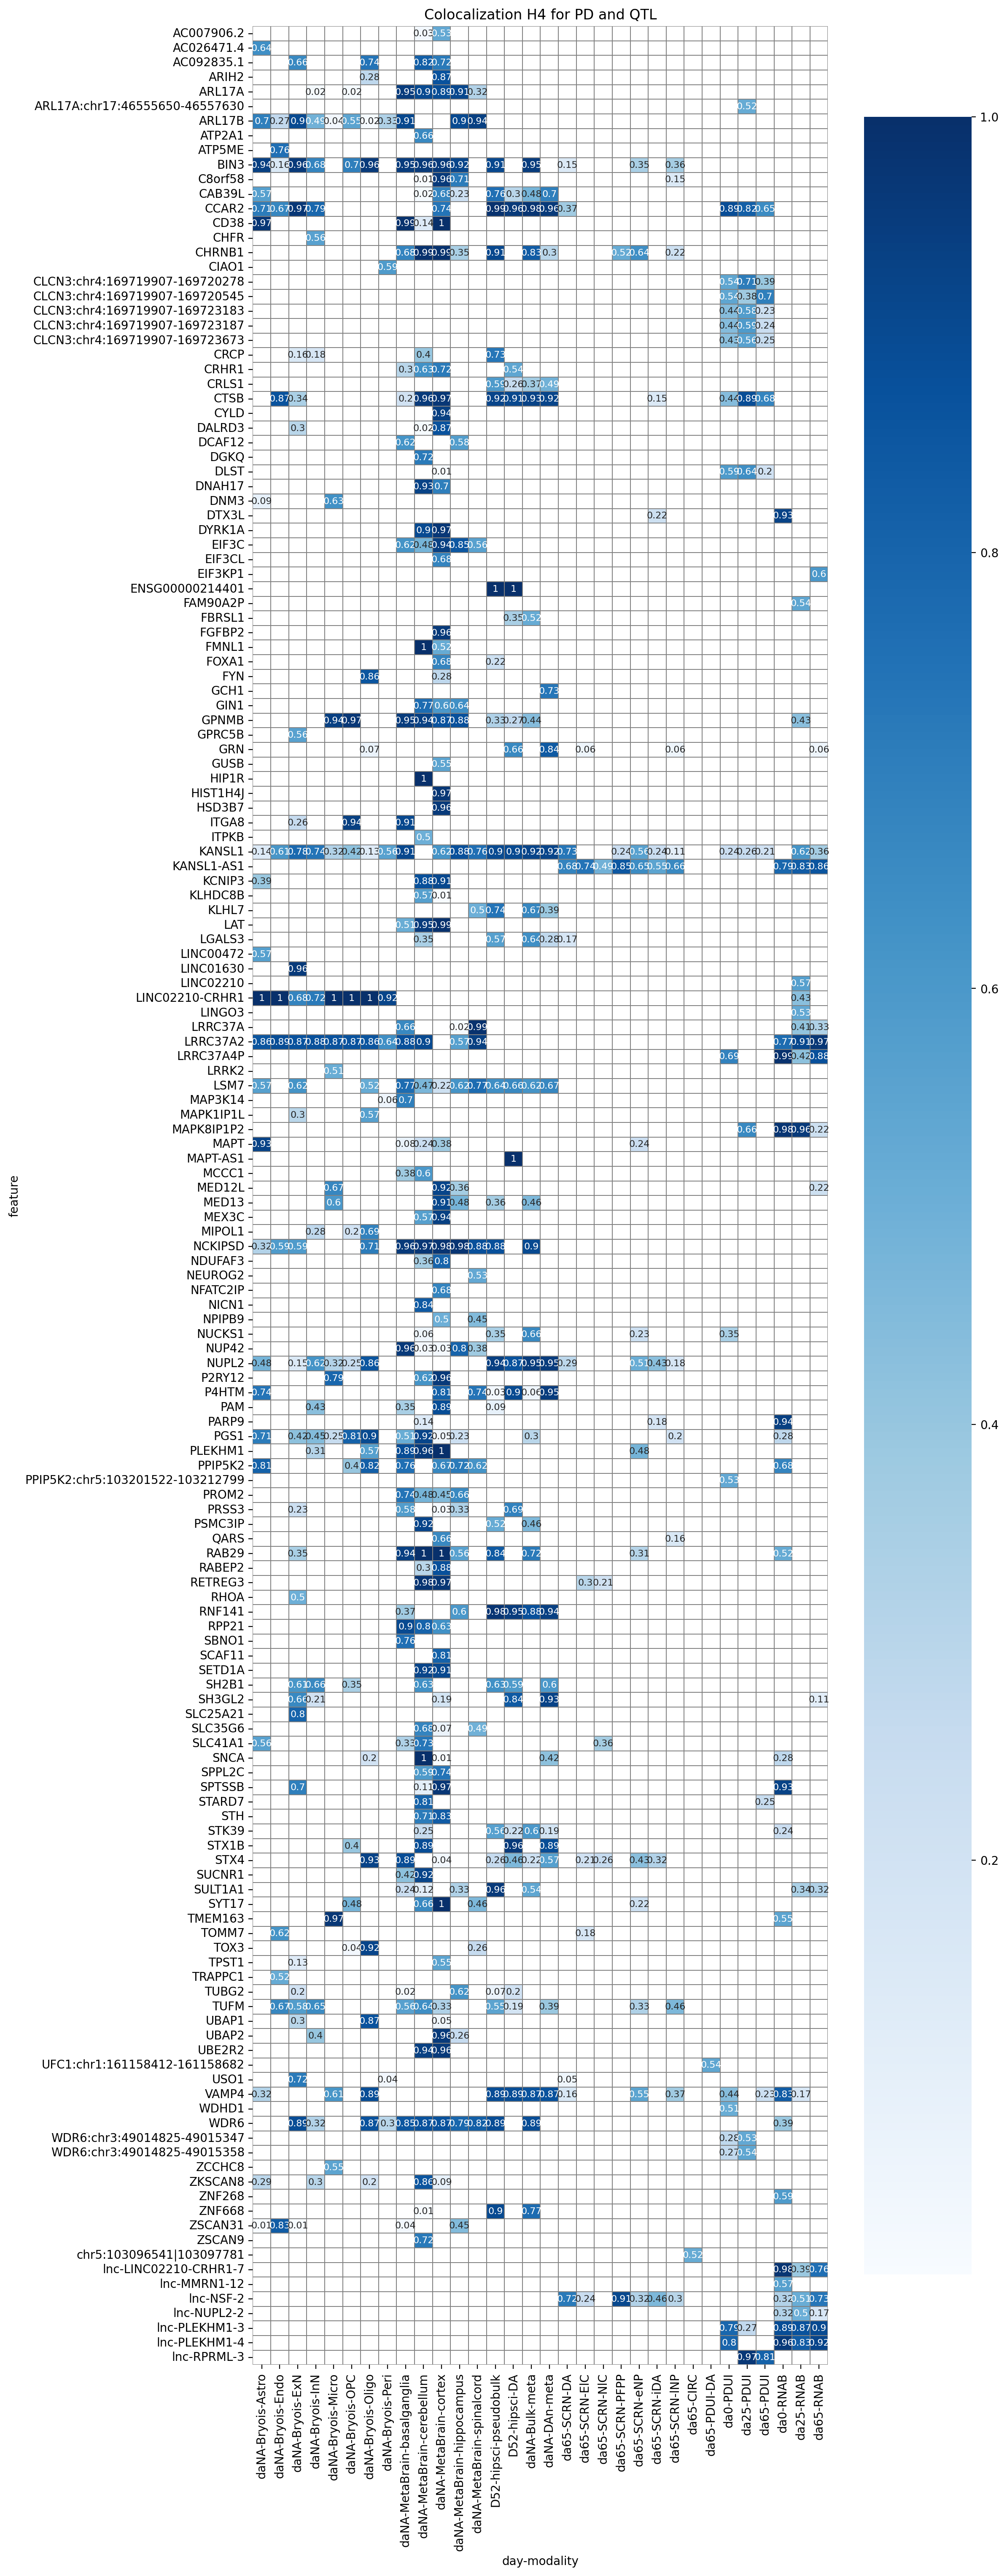

In [16]:
wcoloc_df = wcoloc_df[out_col_order]
if wcoloc_df.shape[0] > 9:
    height = 9+ceil(wcoloc_df.shape[0]/6)
else:
    height = 9
print(dx, height)        
with rc_context({'figure.figsize': (11, height), 'figure.dpi': dpi_value}):
    plt.style.use('seaborn-bright')    
    heatmap(wcoloc_df, annot=True, linecolor='grey',
            annot_kws={"fontsize":8}, linewidths=0.05, cmap='Blues')    
    plt.title(f'Colocalization H4 for {dx} and QTL')
    plt.savefig(figure_file, dpi=dpi_value, bbox_inches='tight', 
                transparent=True, pad_inches=1)
    plt.show()

### visualize colocalization heatmap by modality and sorted

DAn-meta
(15, 32)


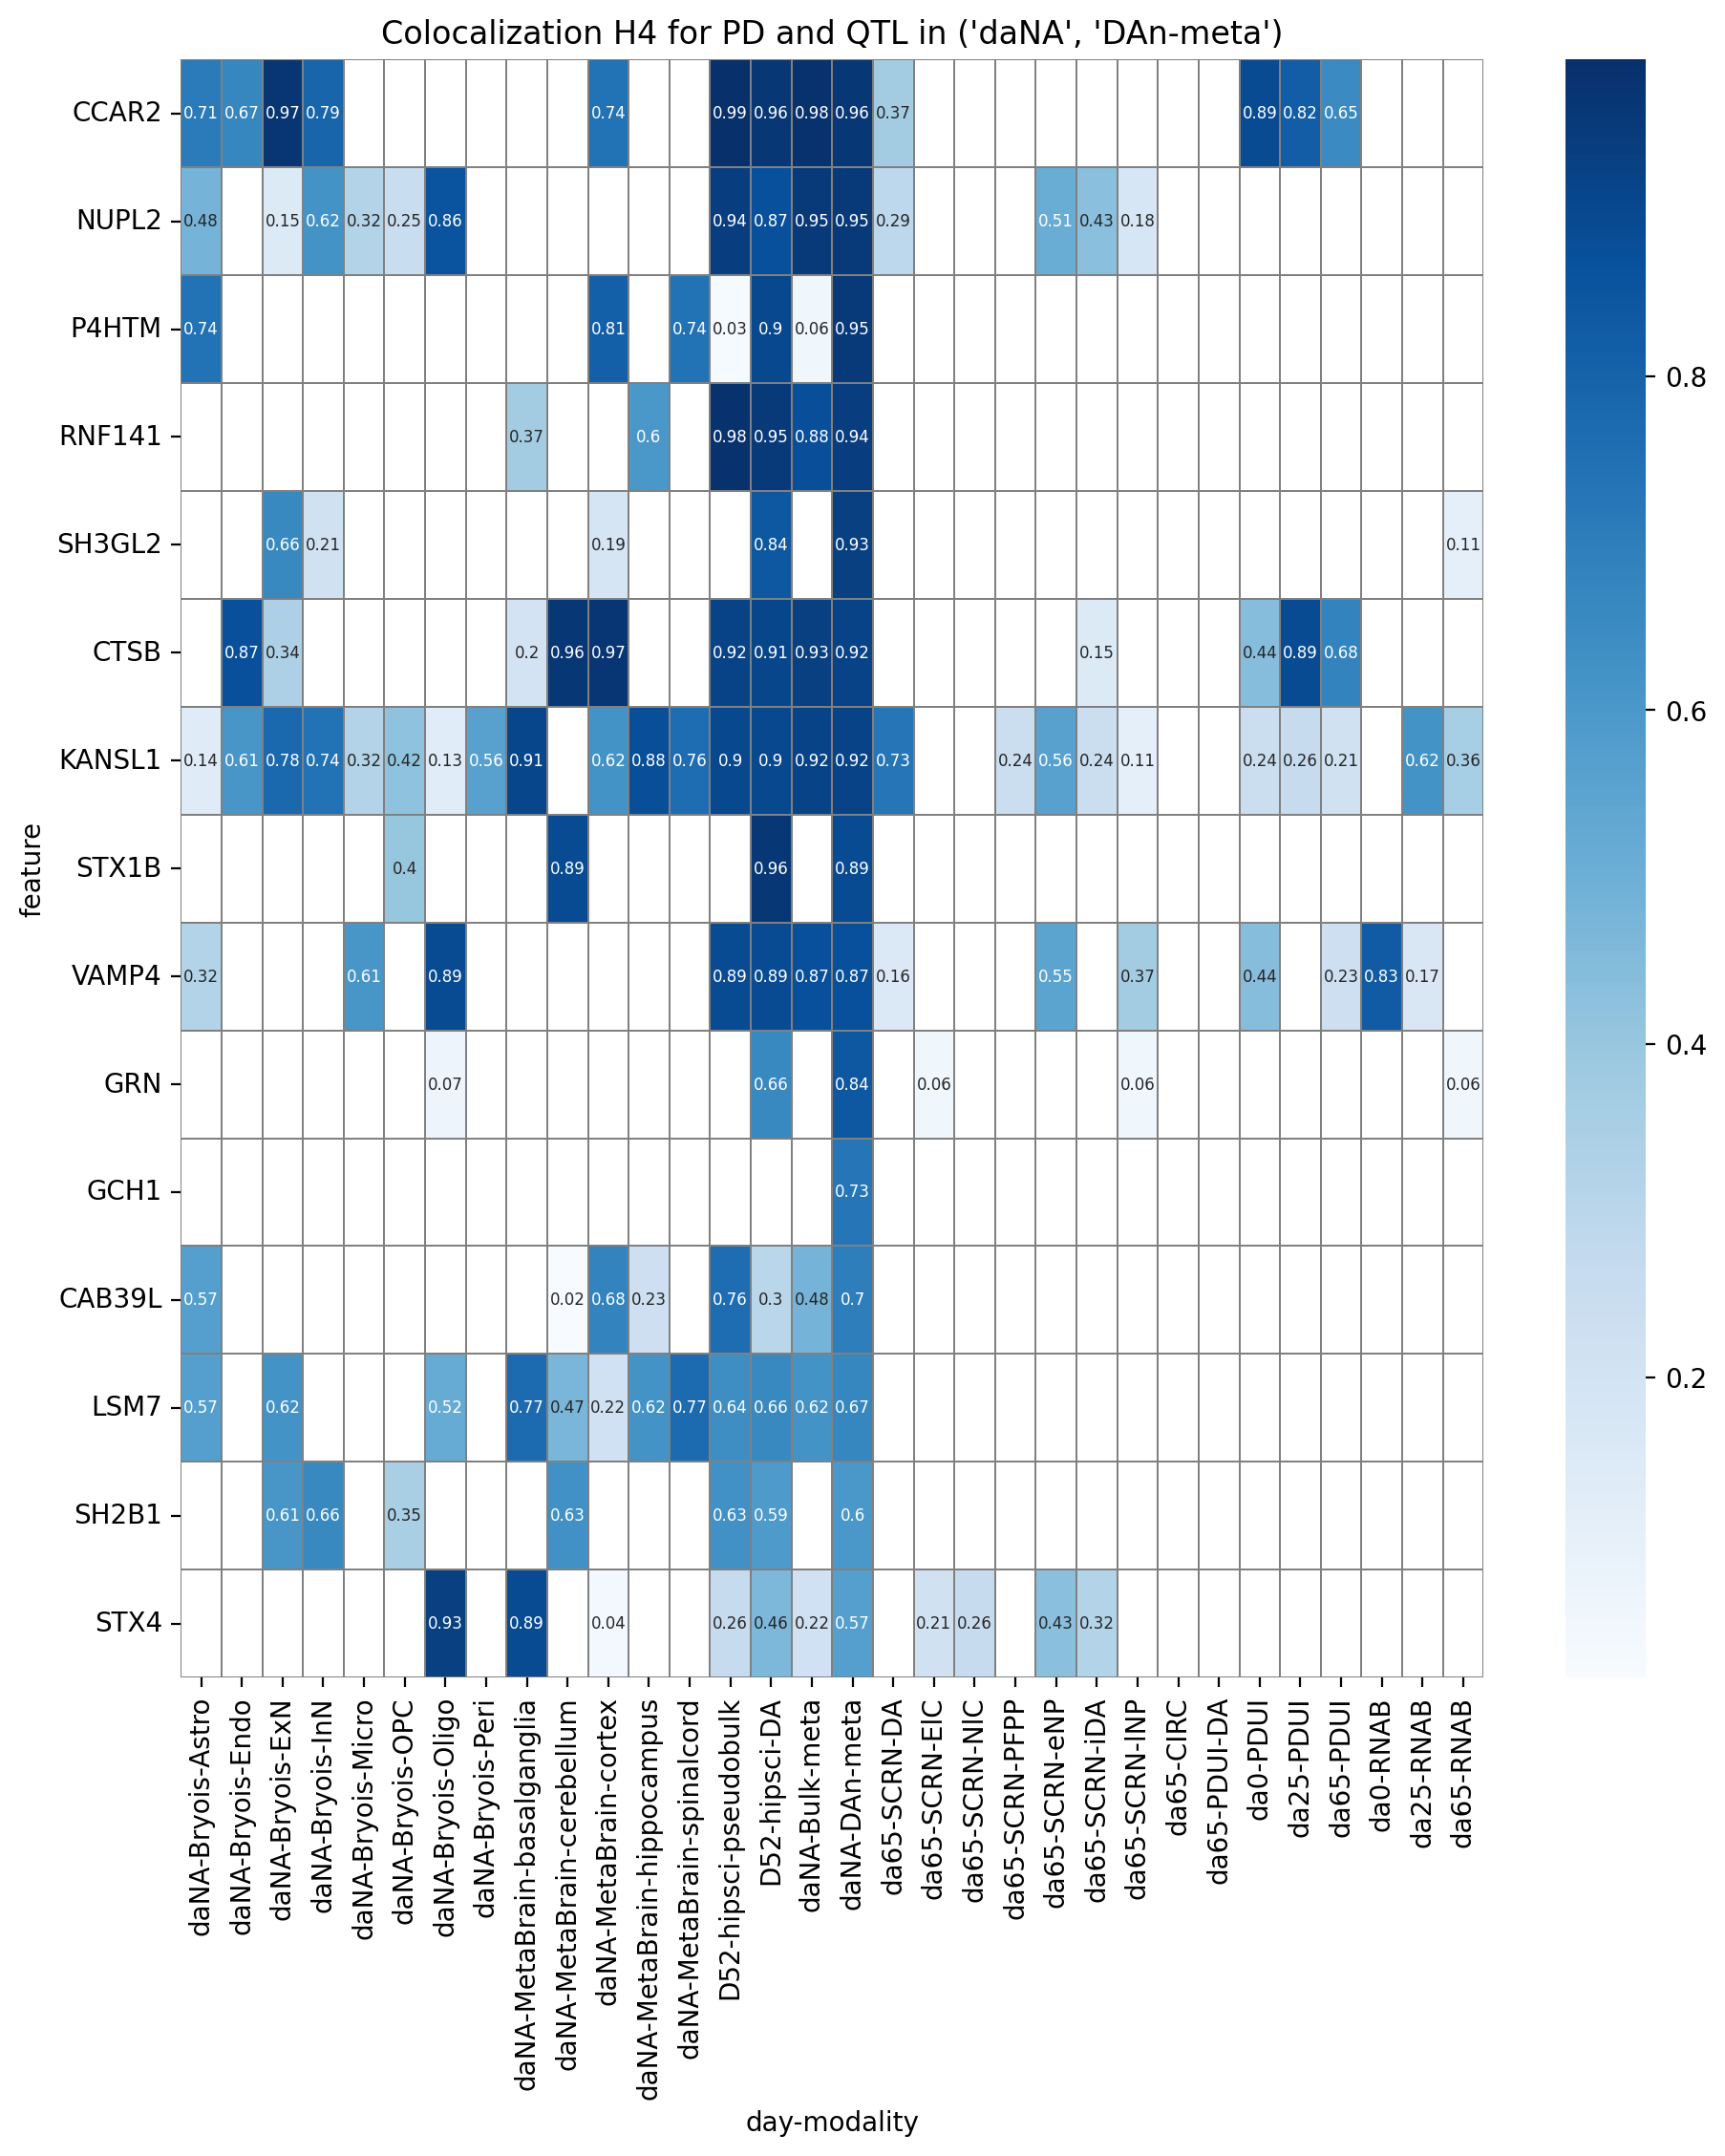

Bulk-meta
(19, 32)


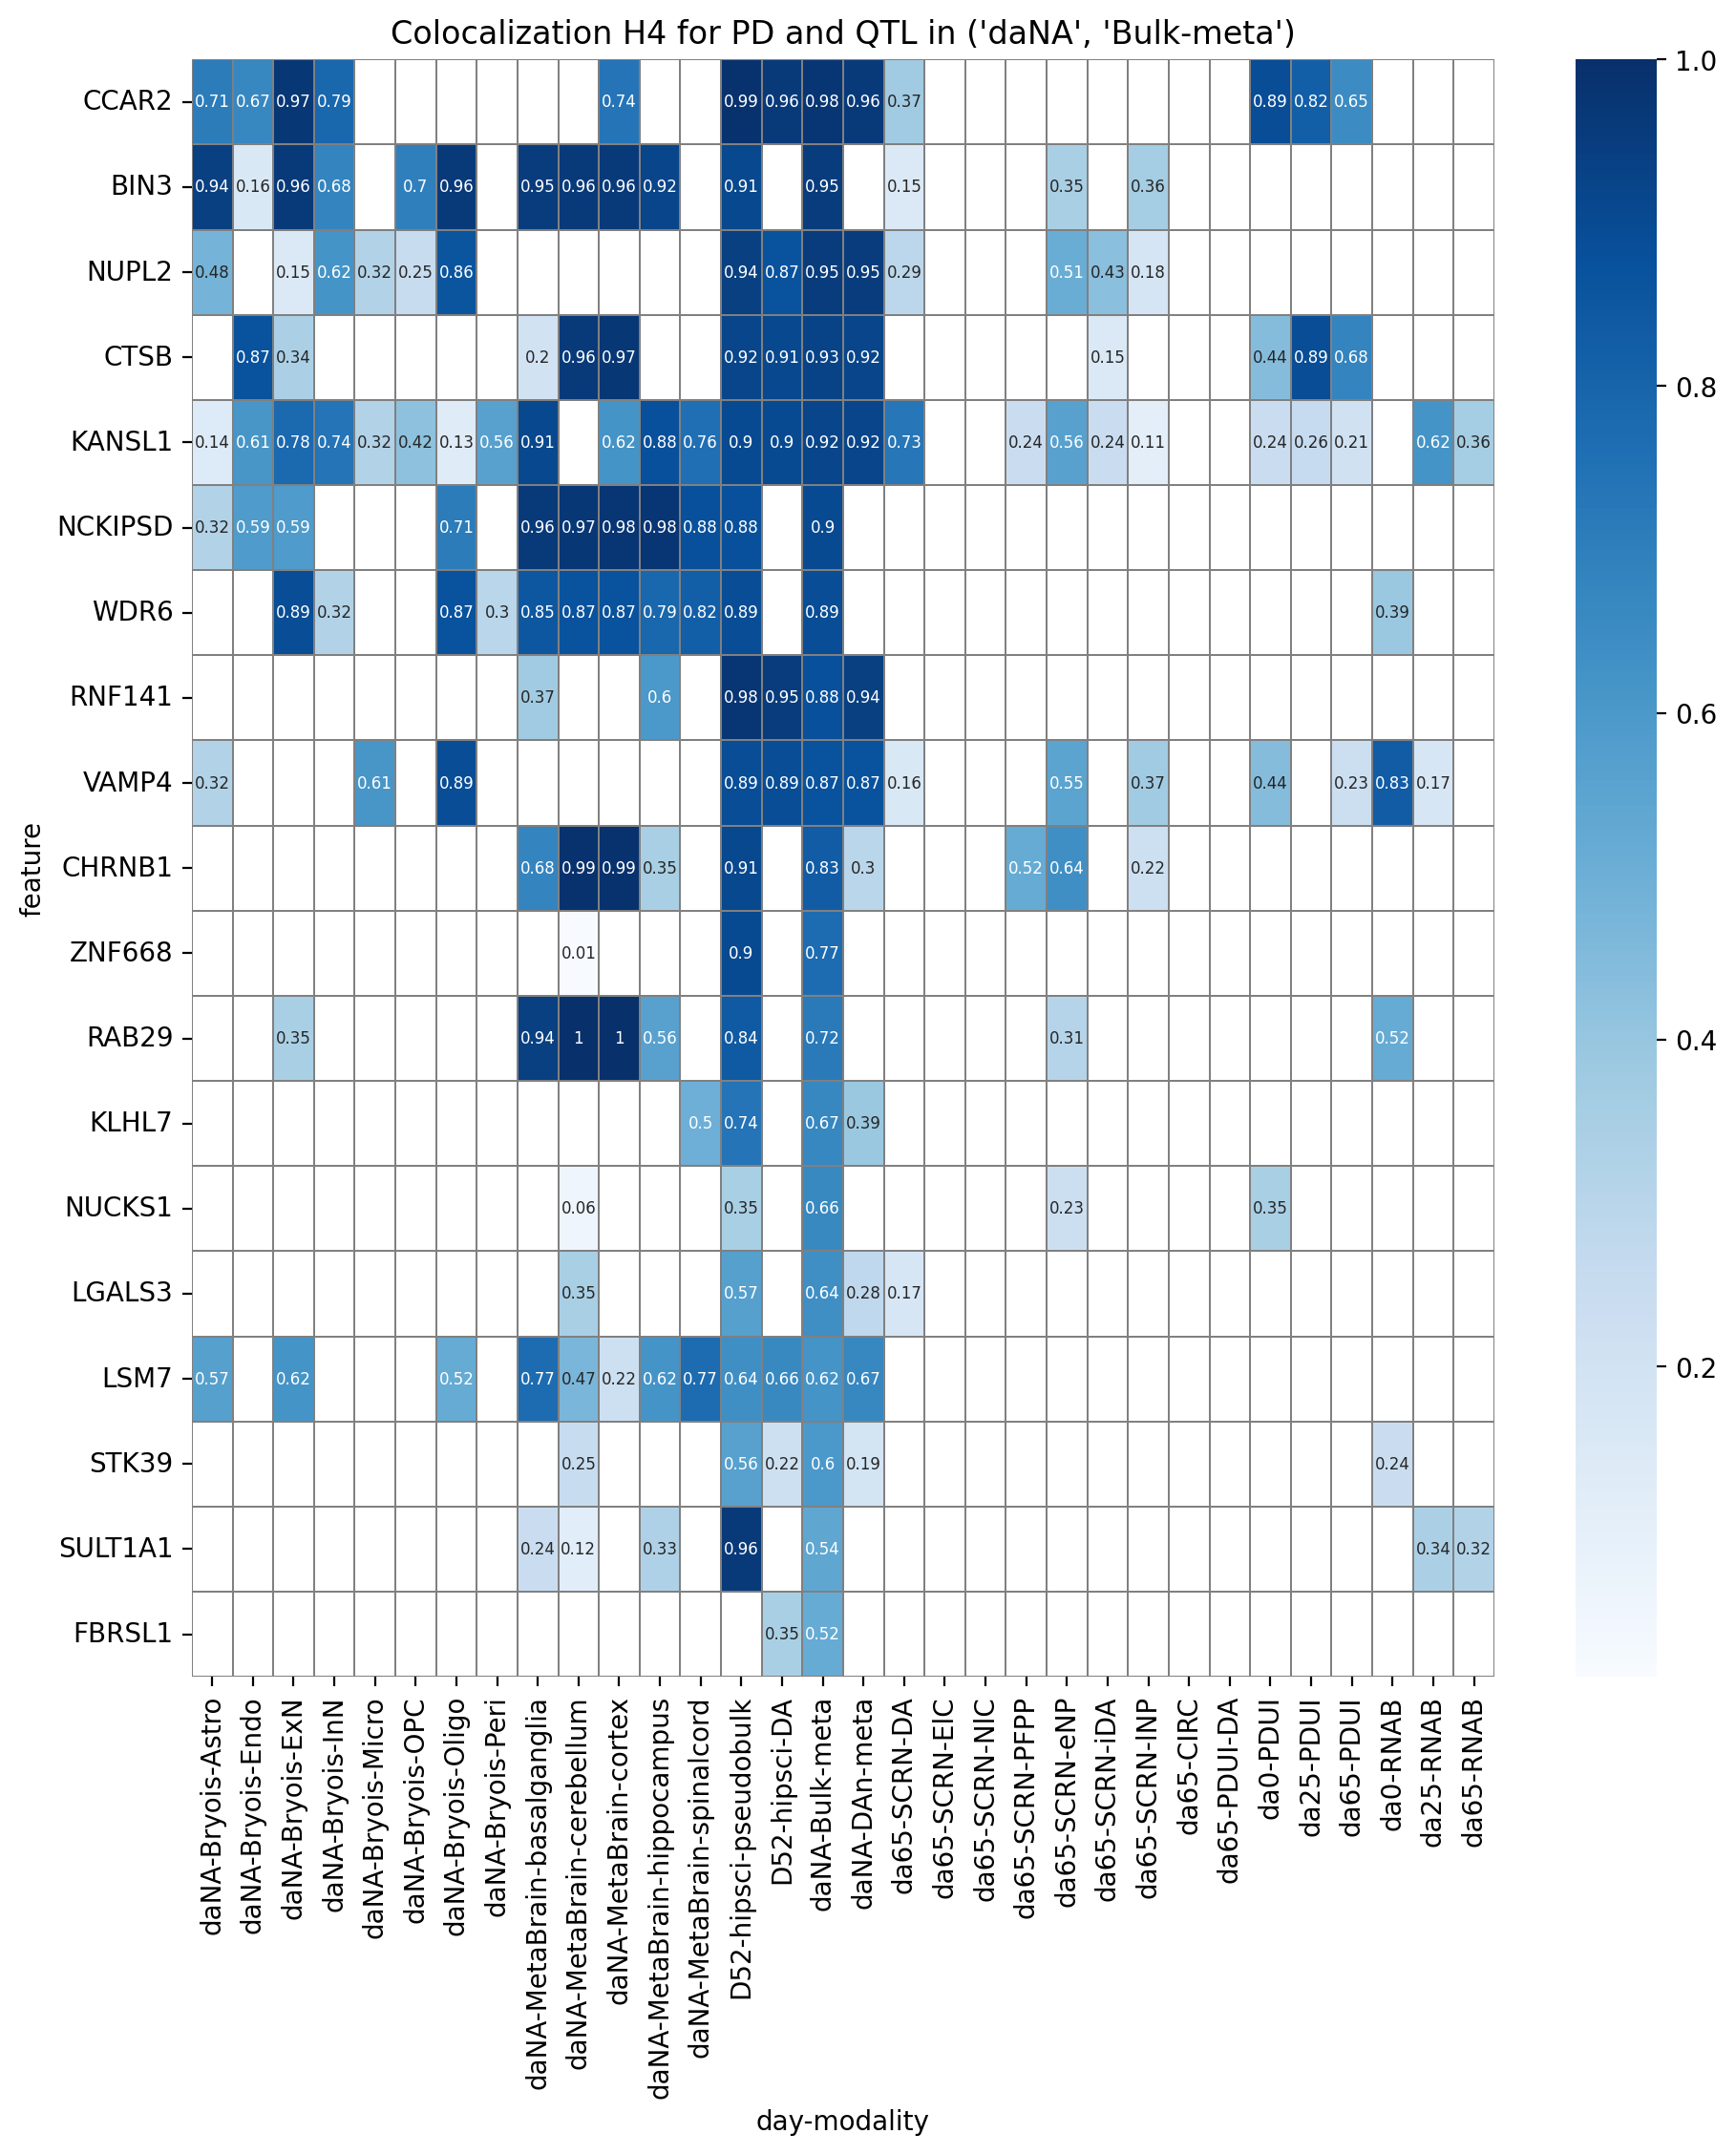

PDUI
(4, 32)


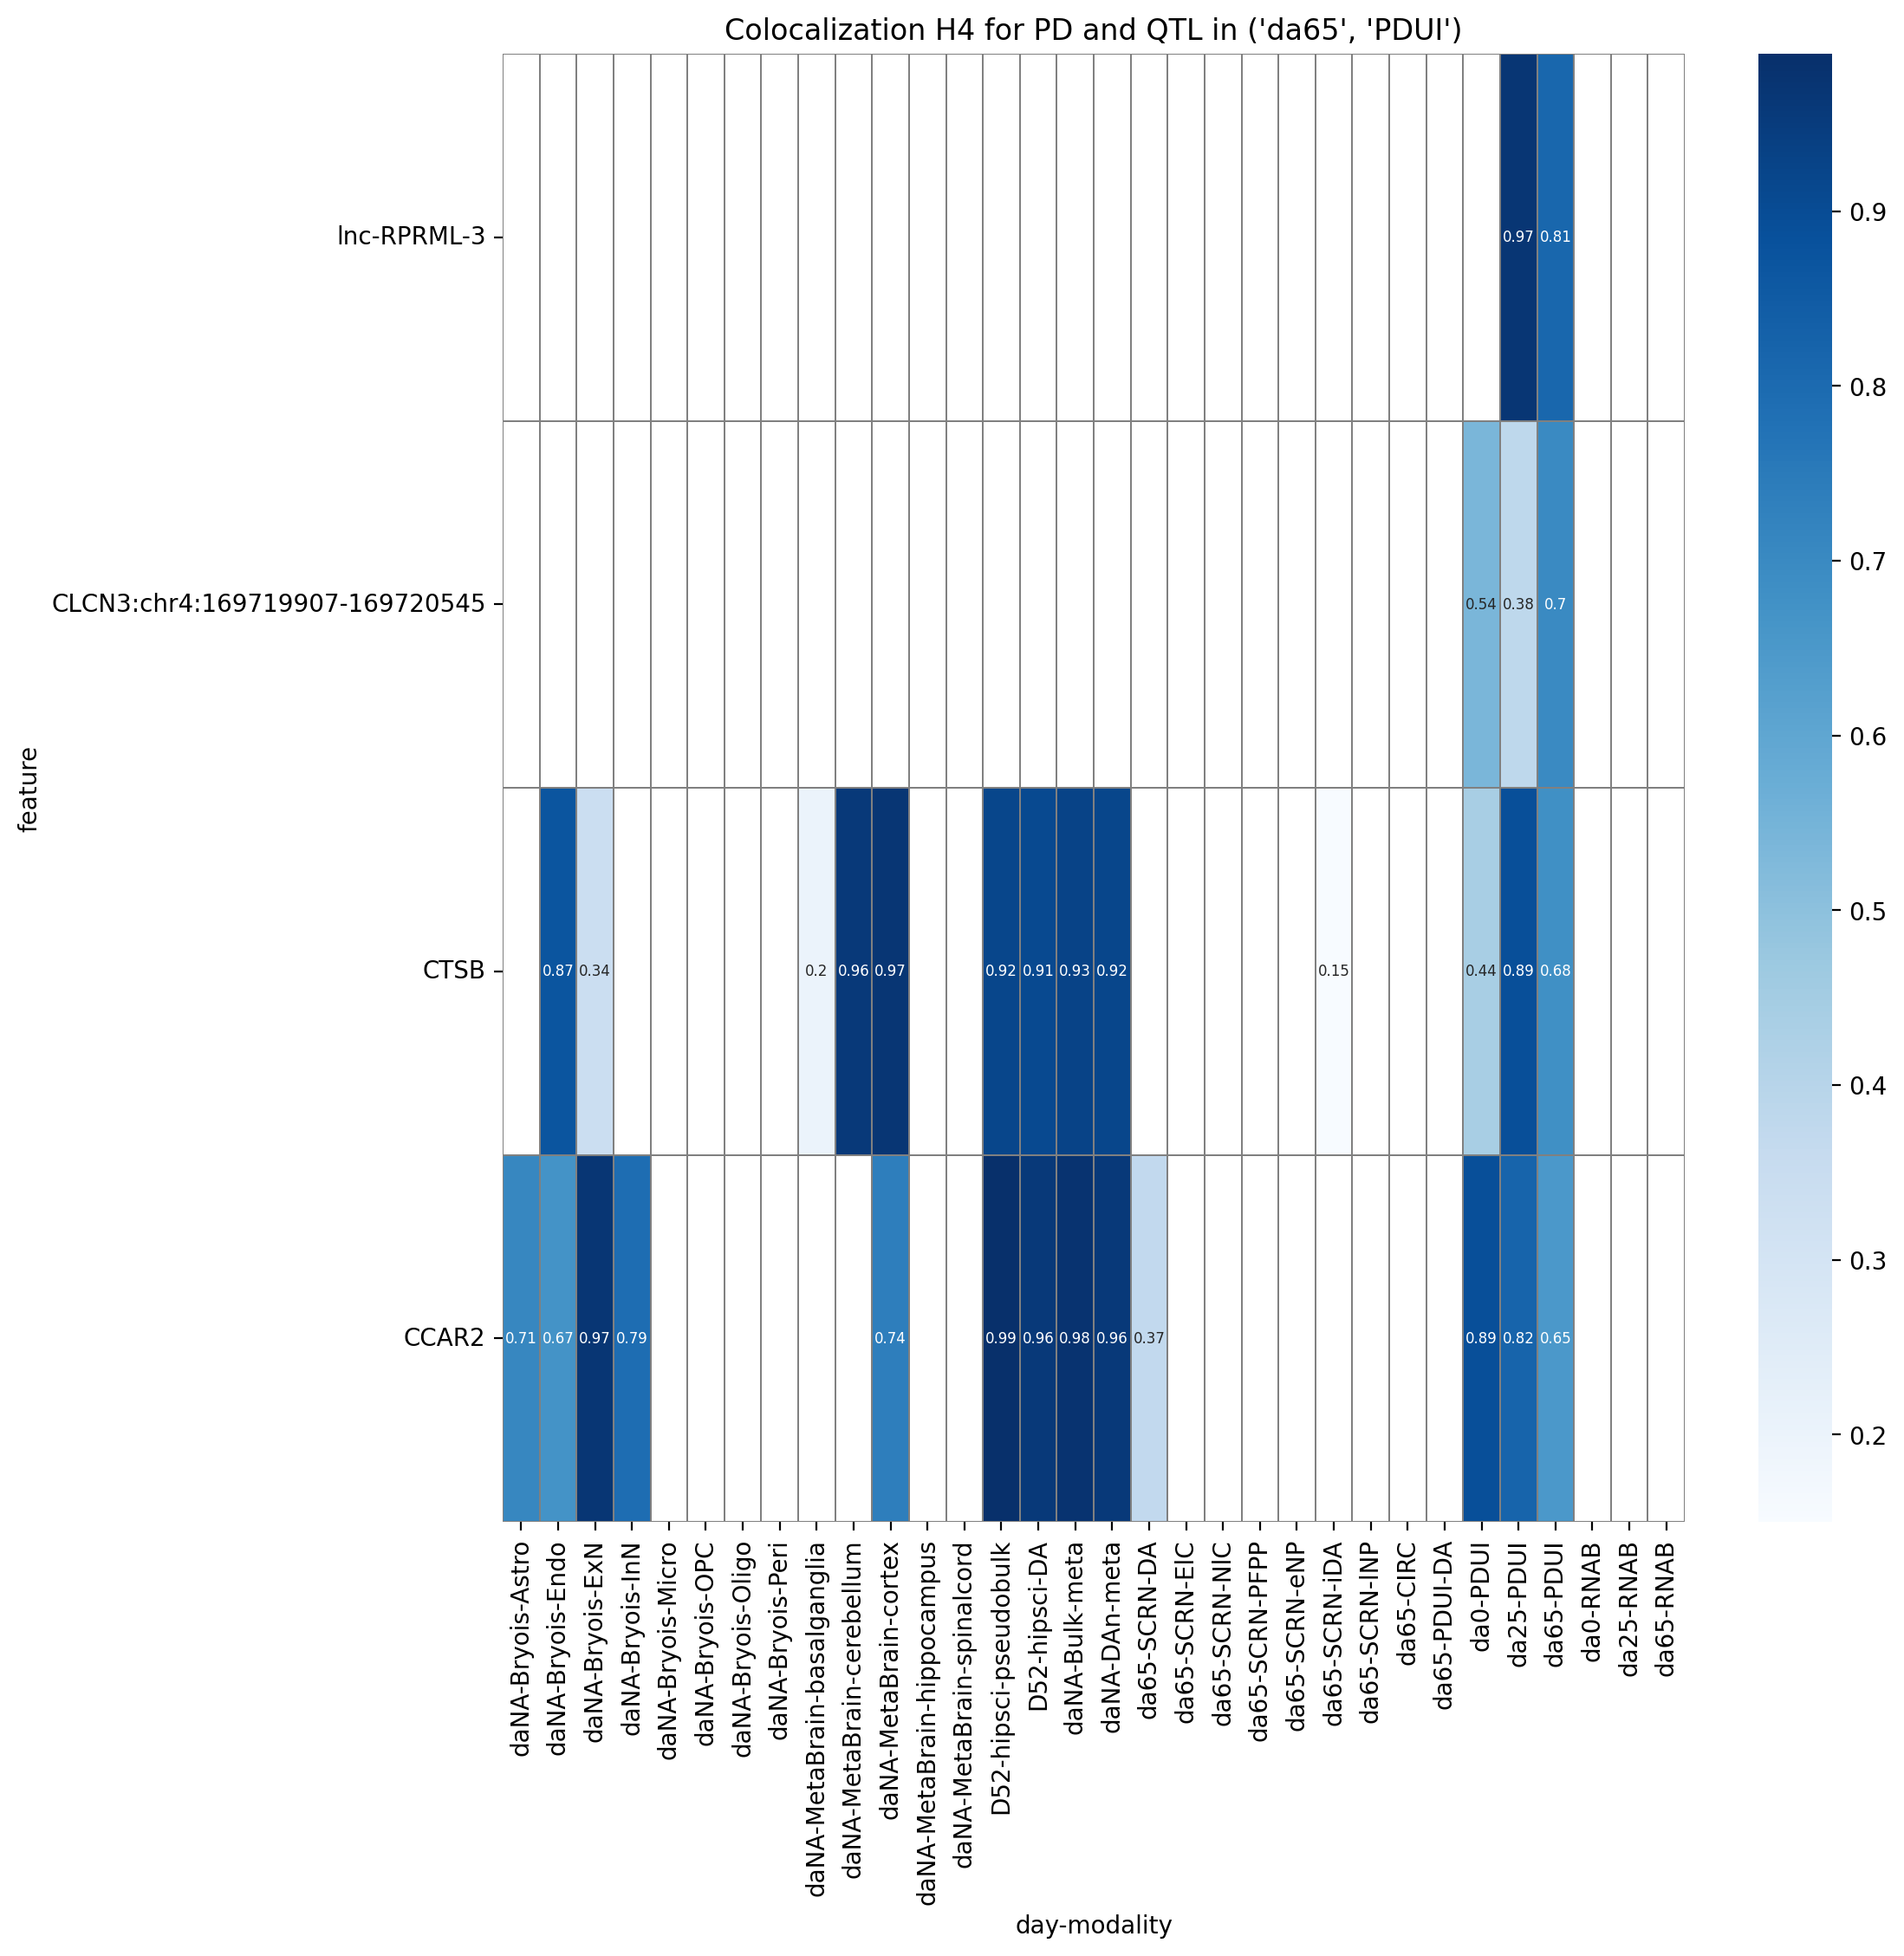

PDUI-DA
(1, 32)


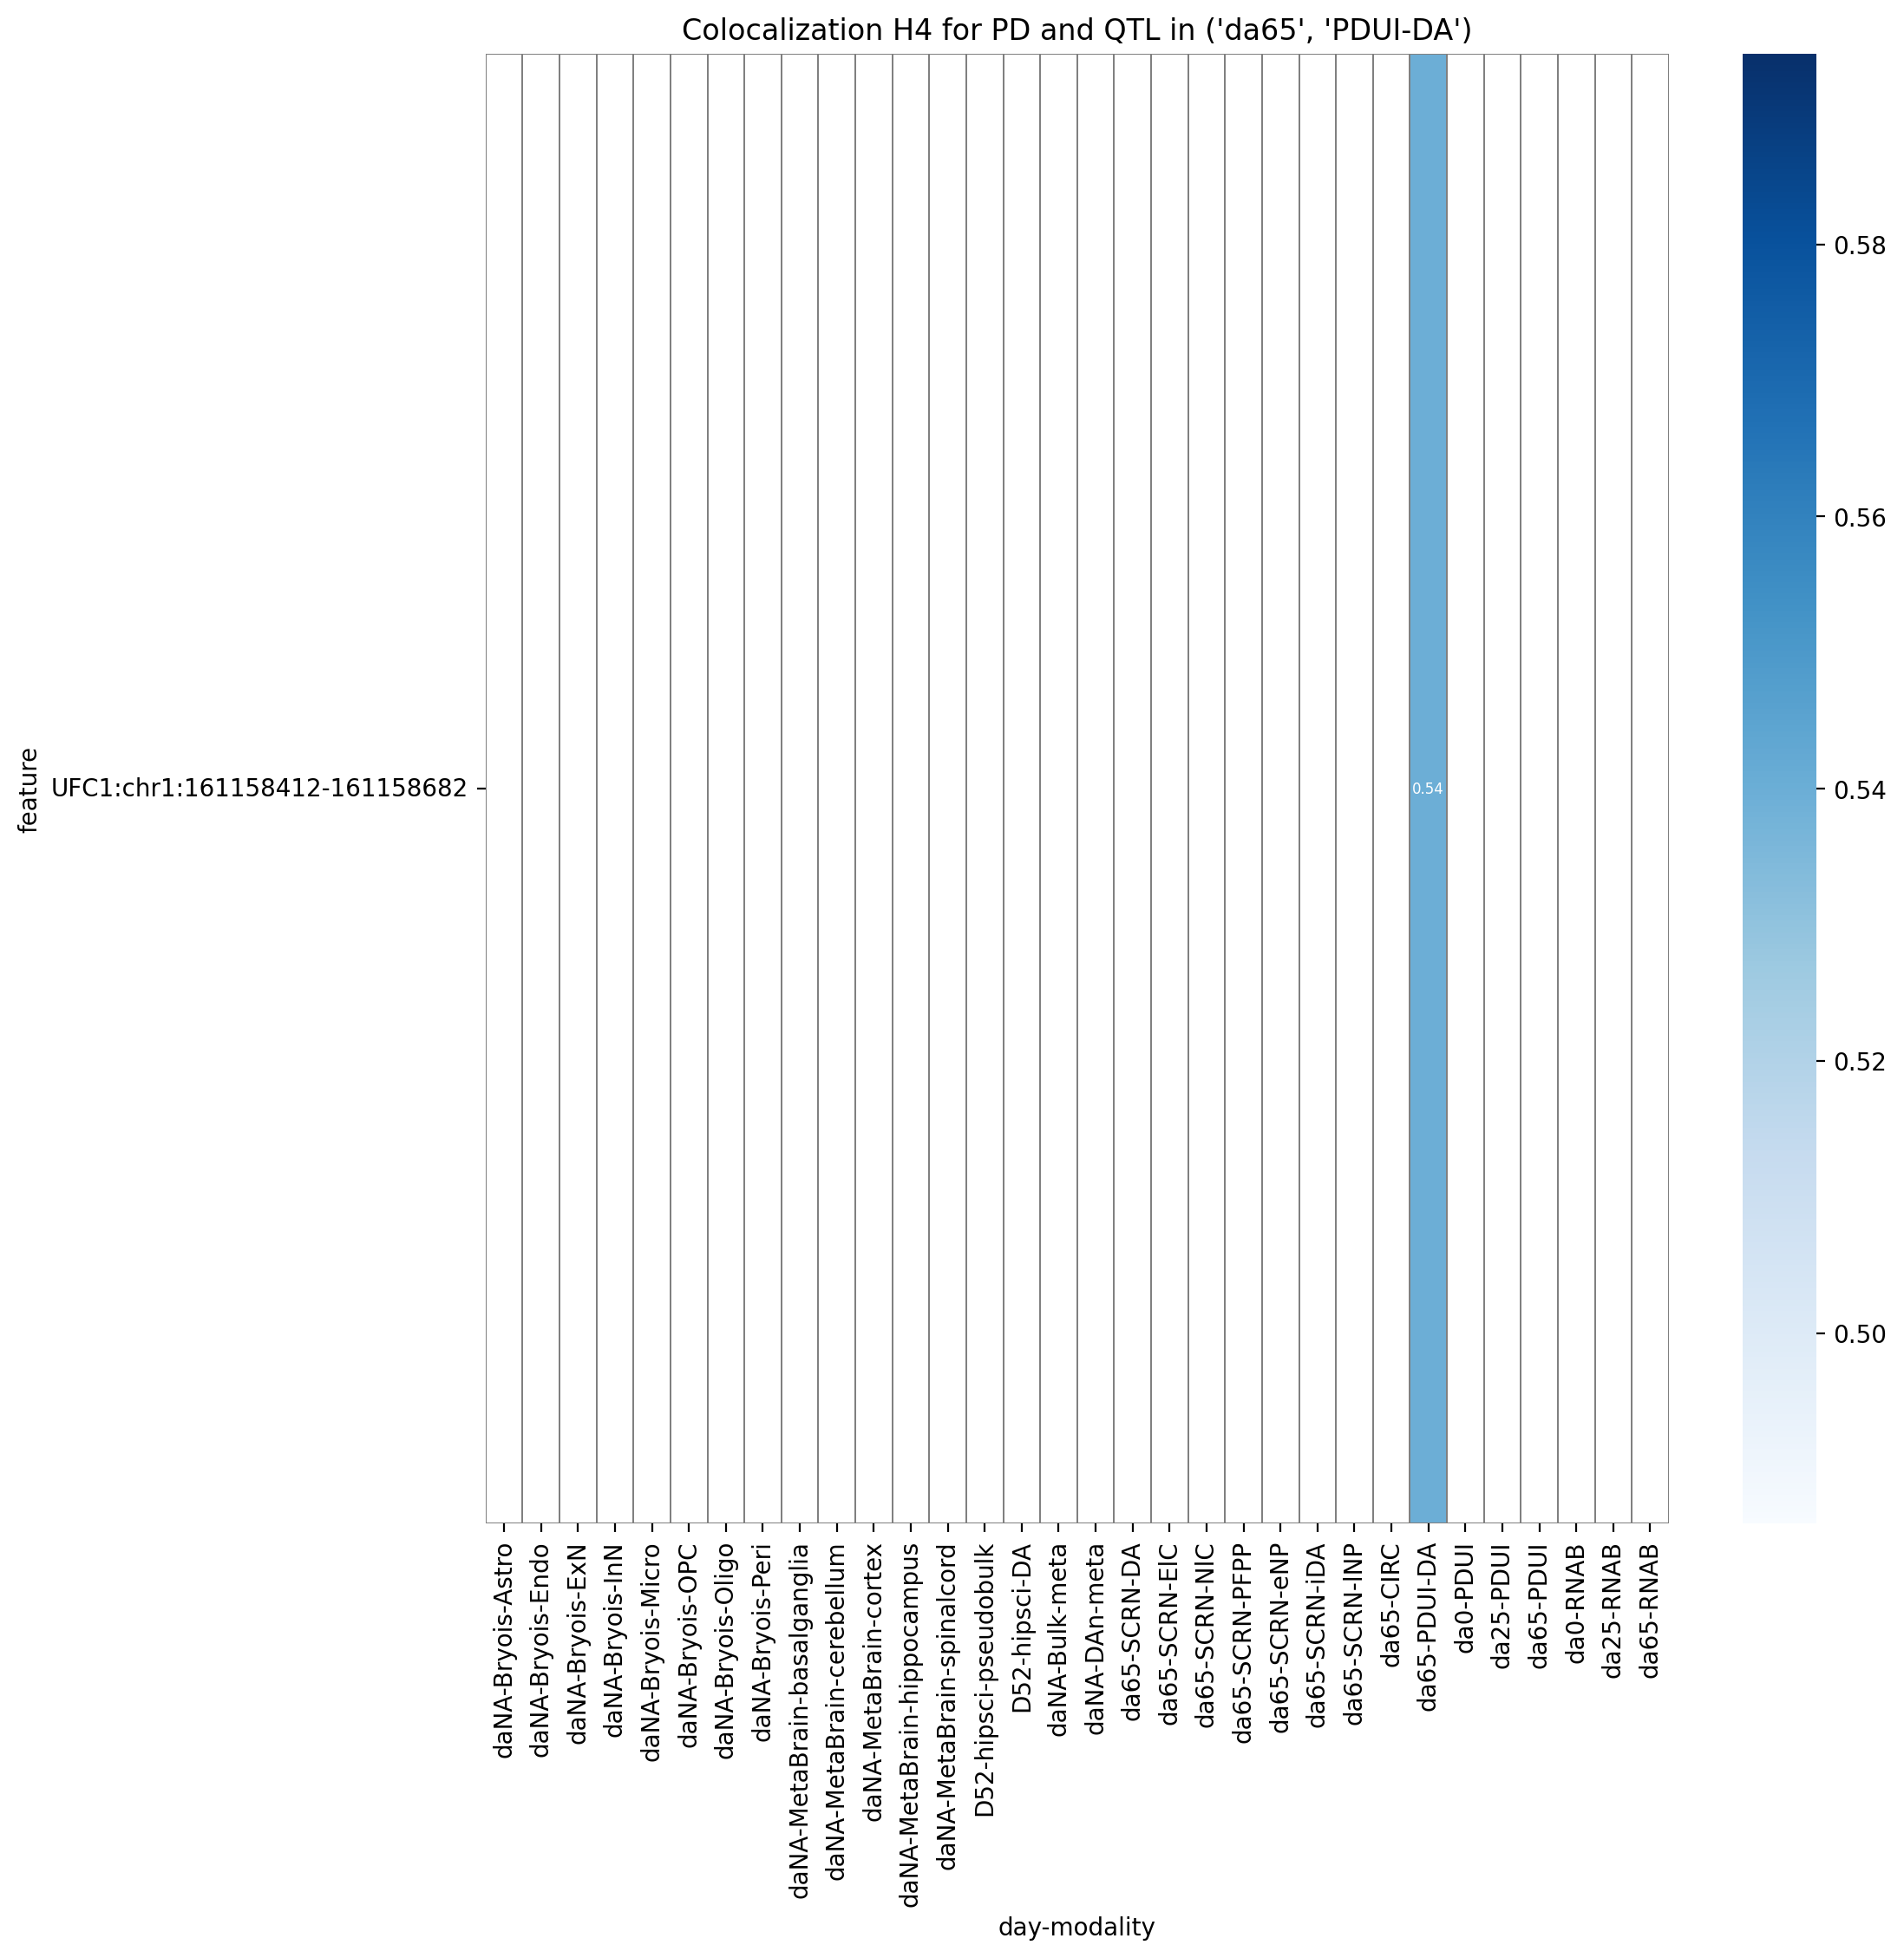

Bryois-ExN
(18, 32)


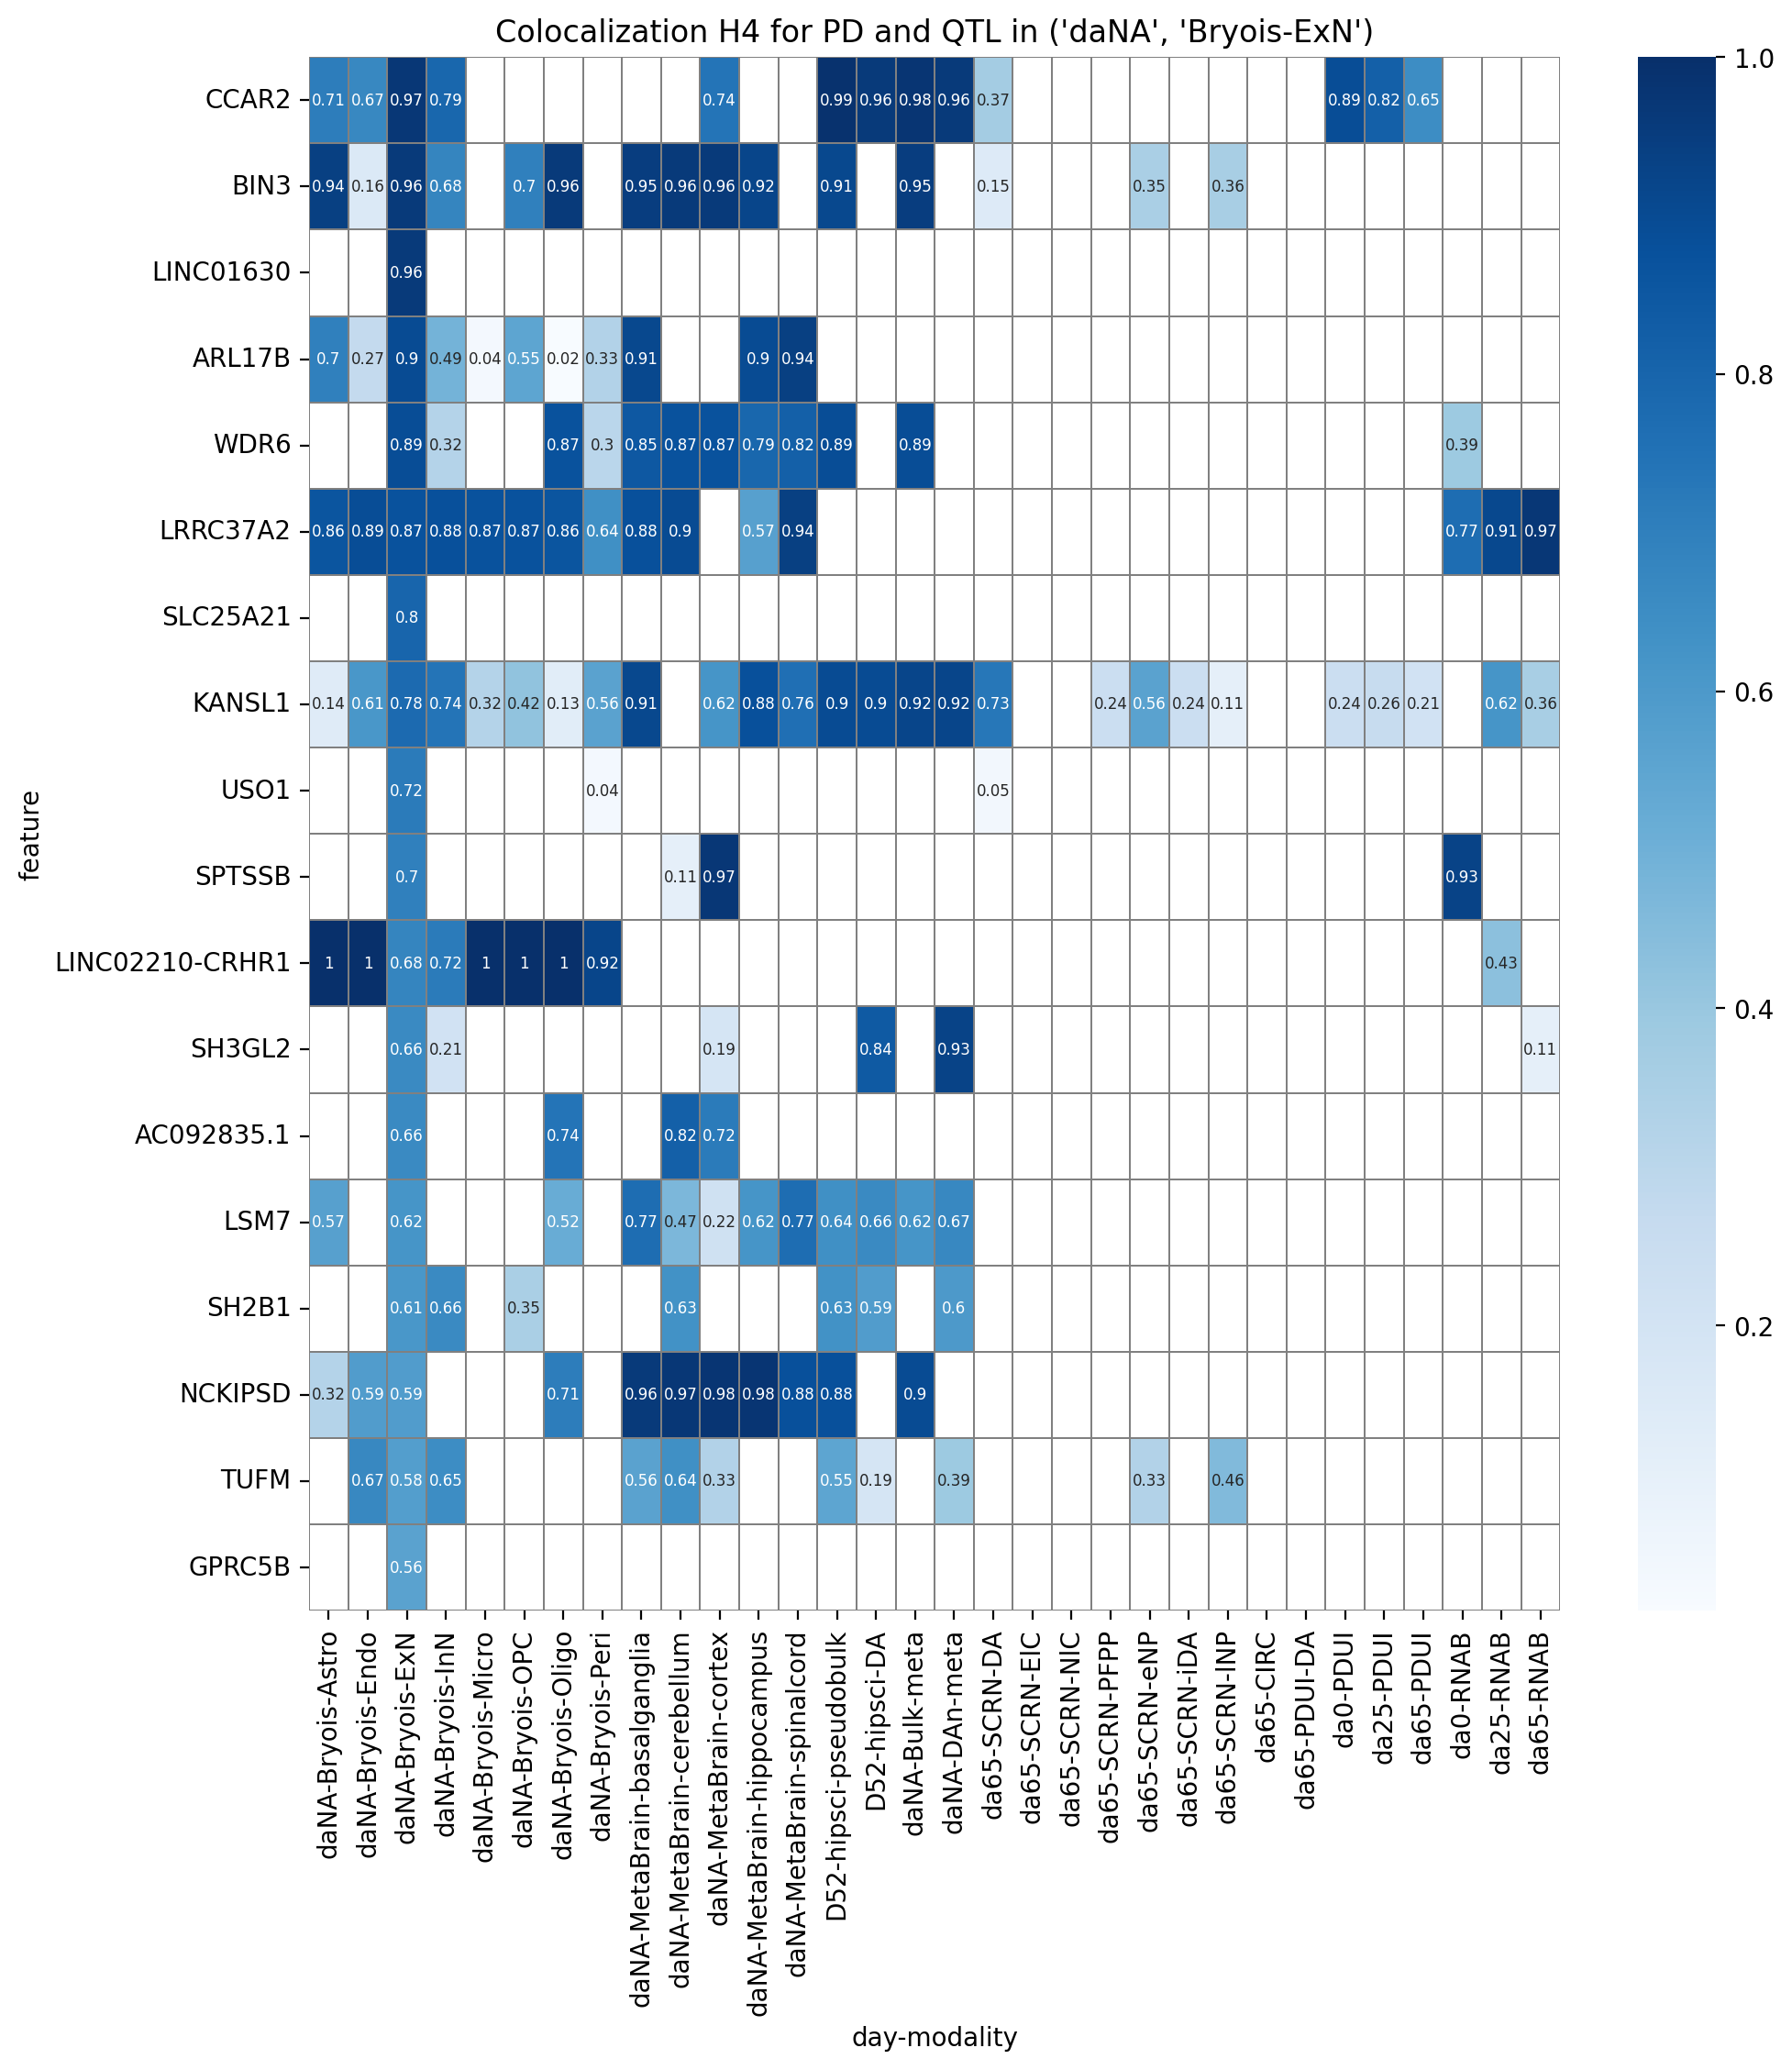

Bryois-InN
(9, 32)


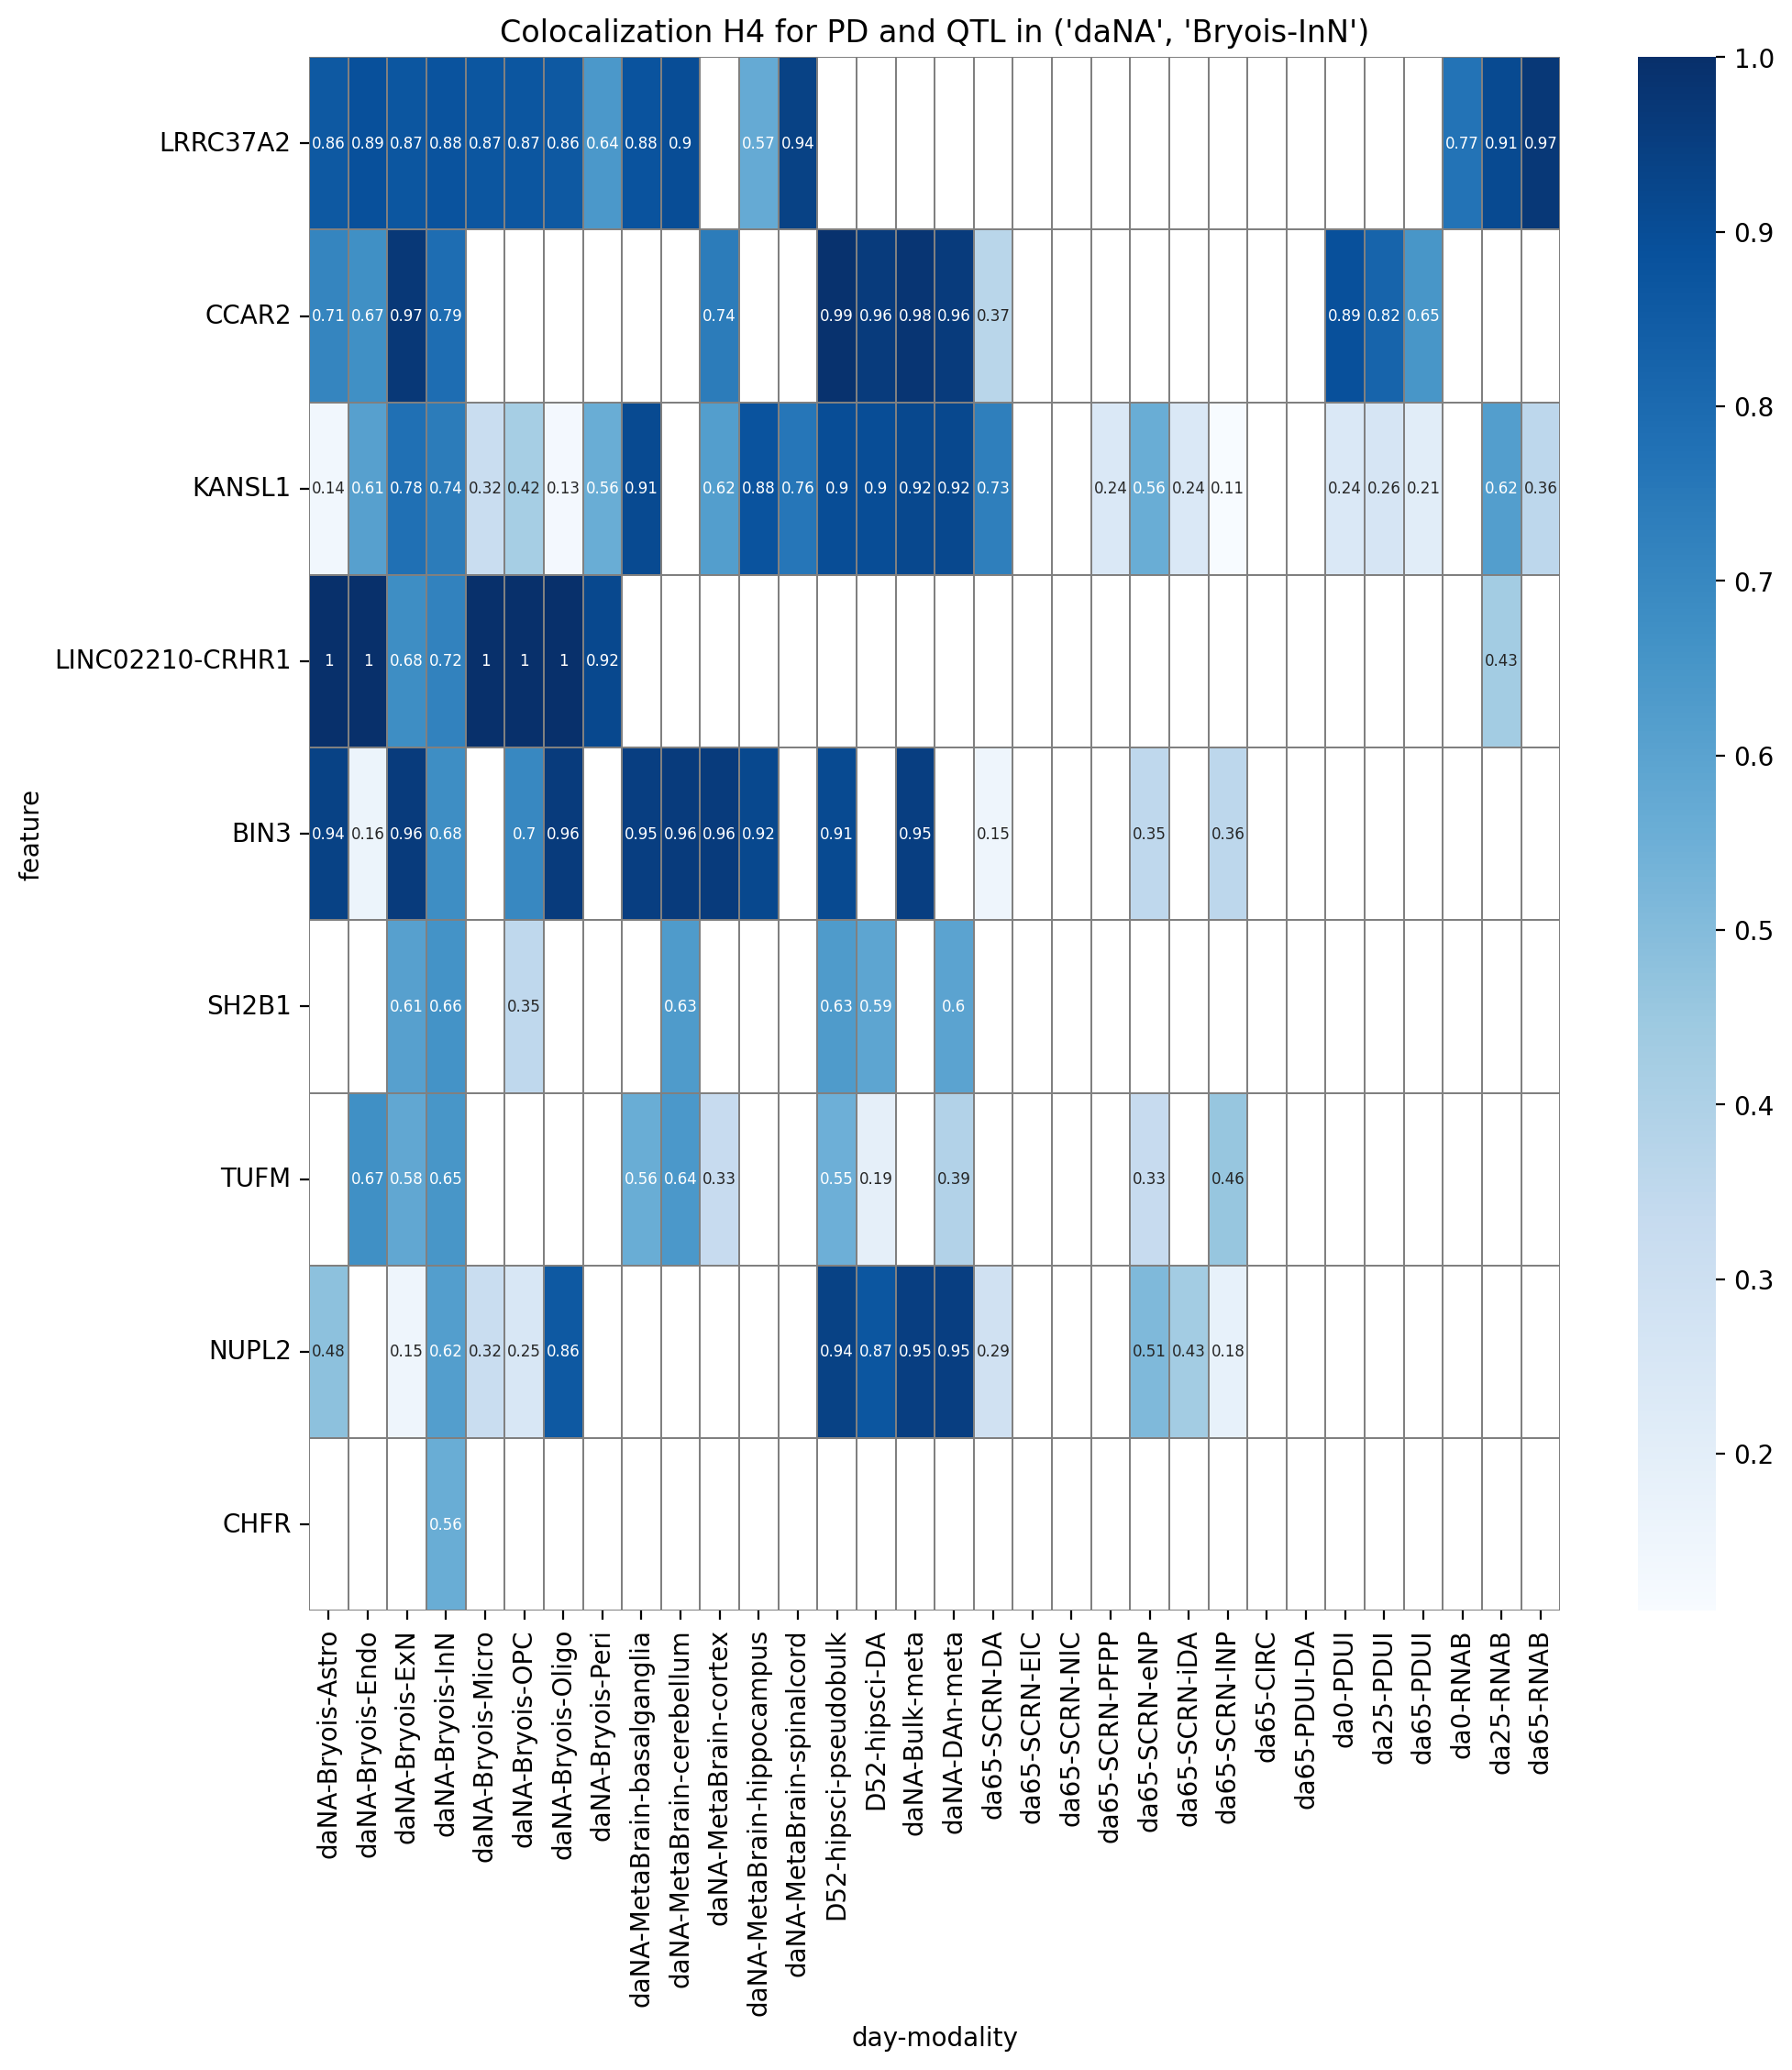

Bryois-Micro
(11, 32)


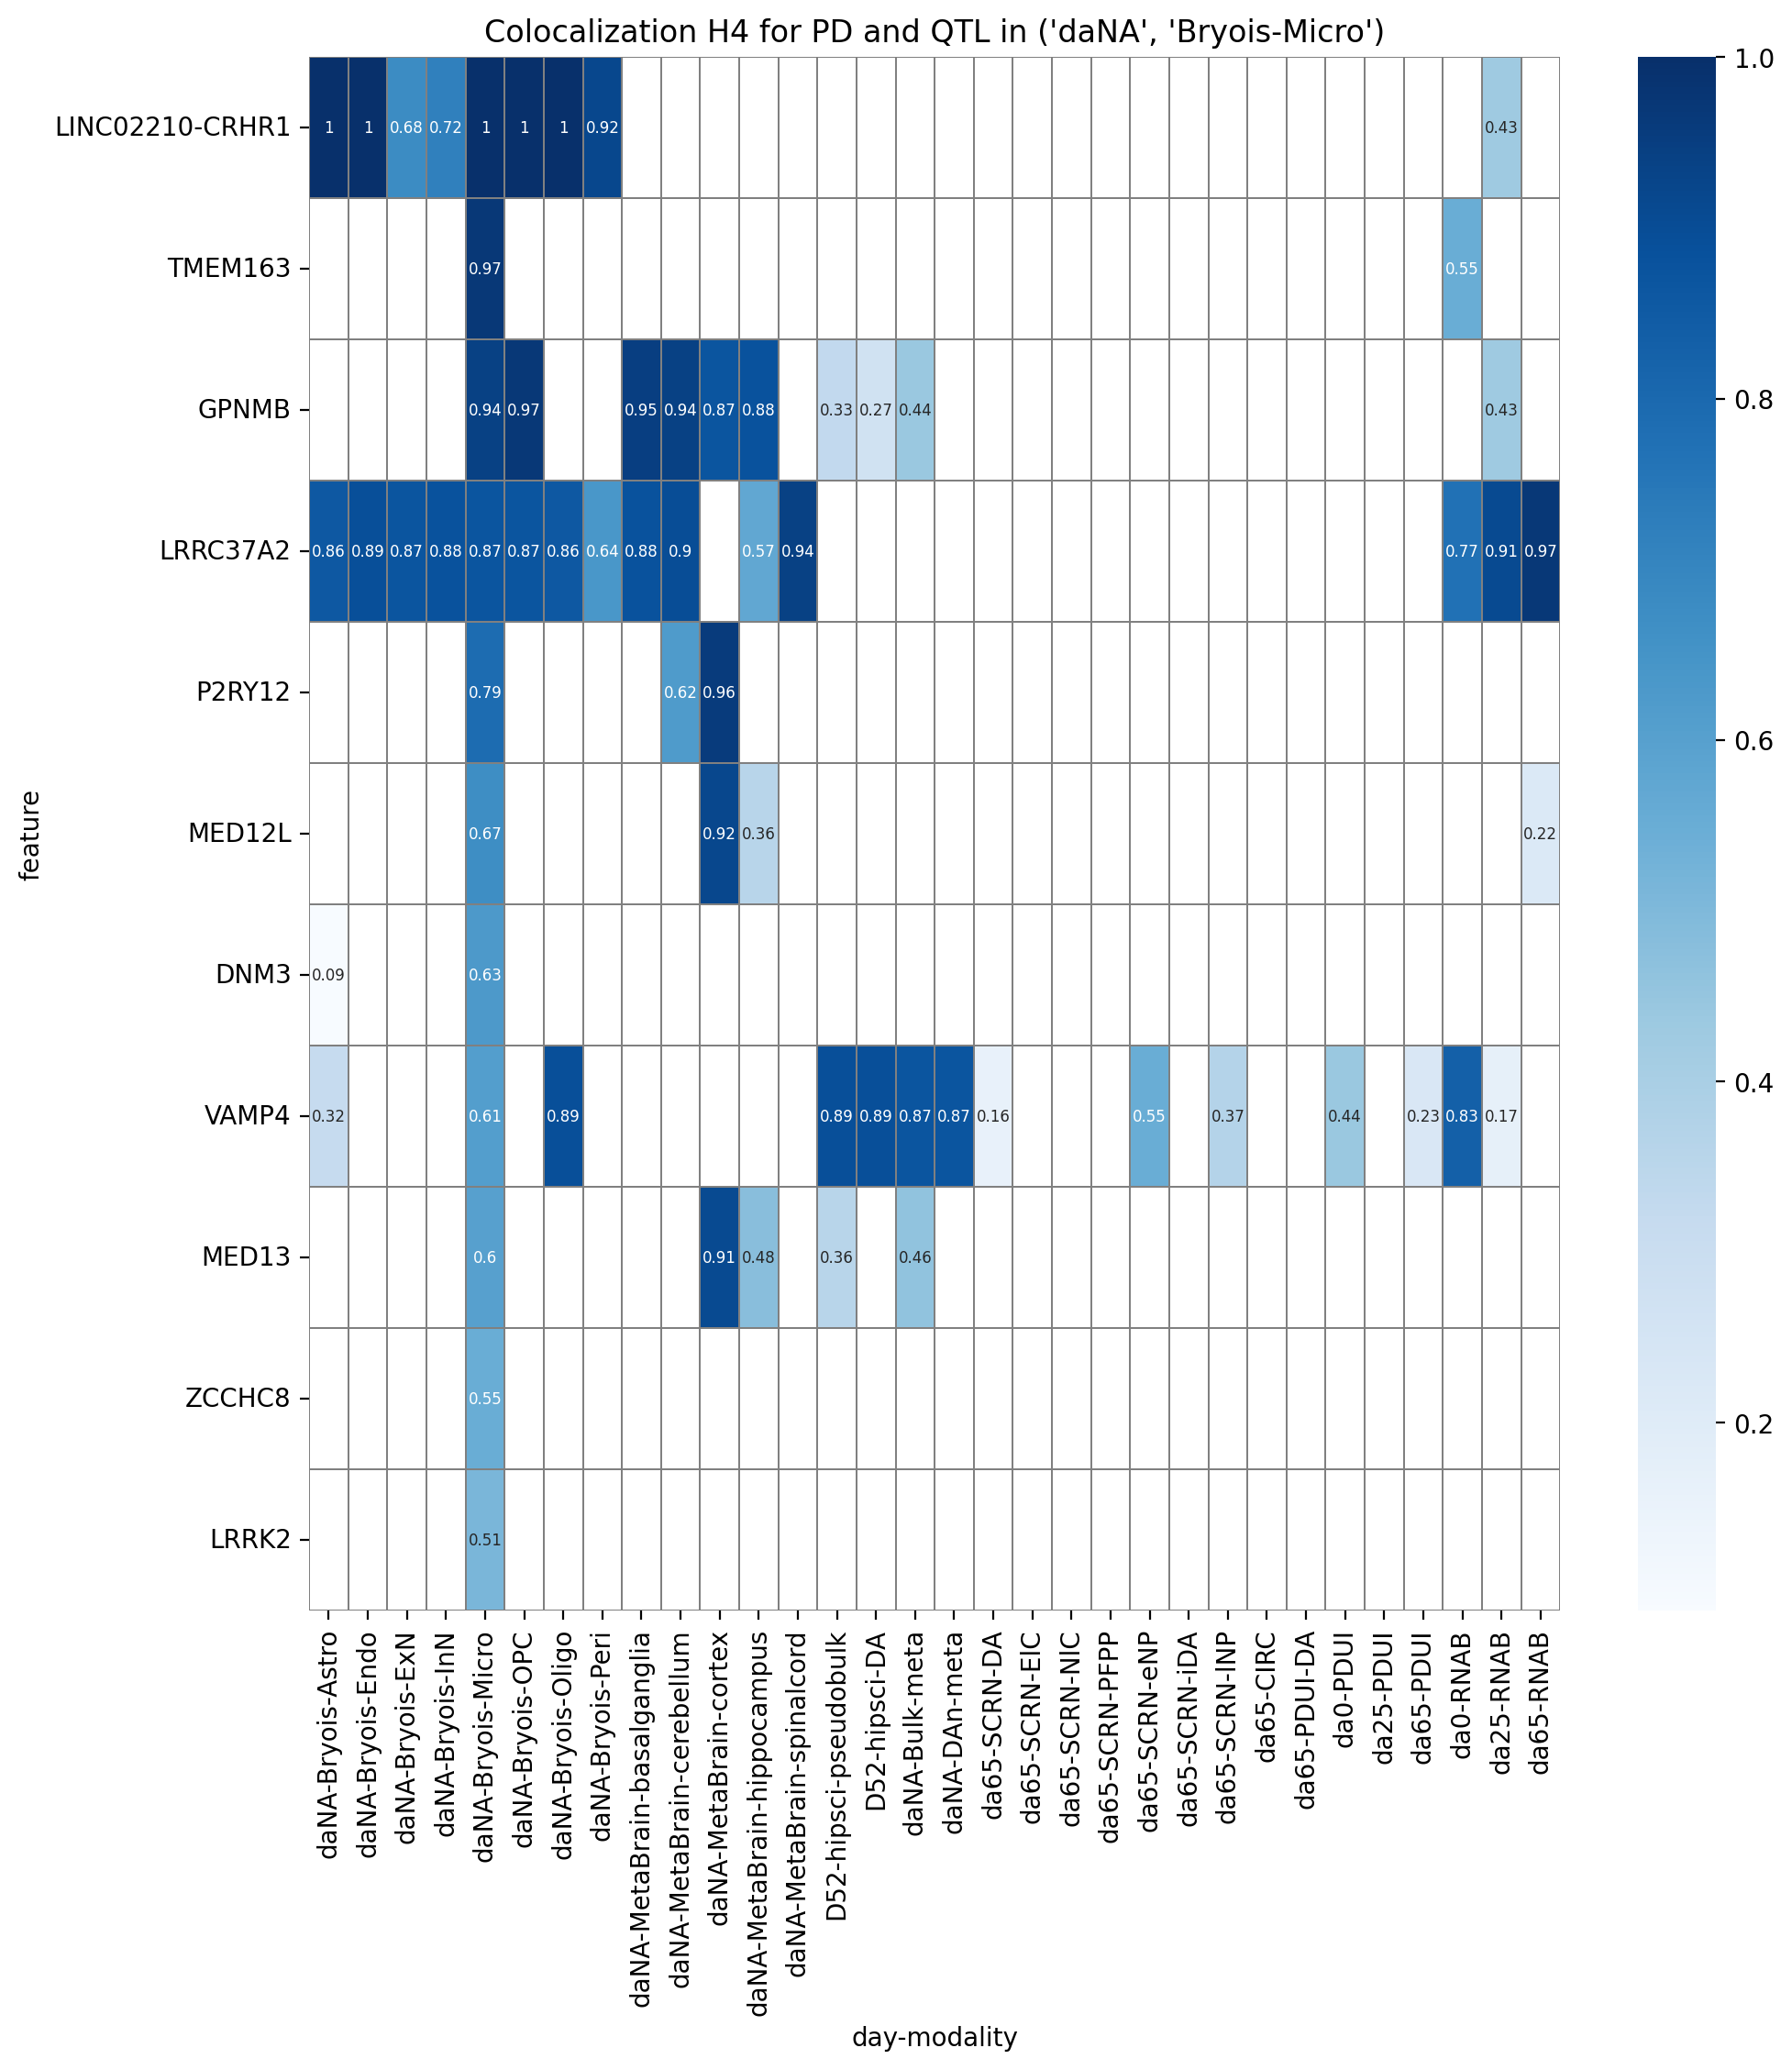

Bryois-Astro
(15, 32)


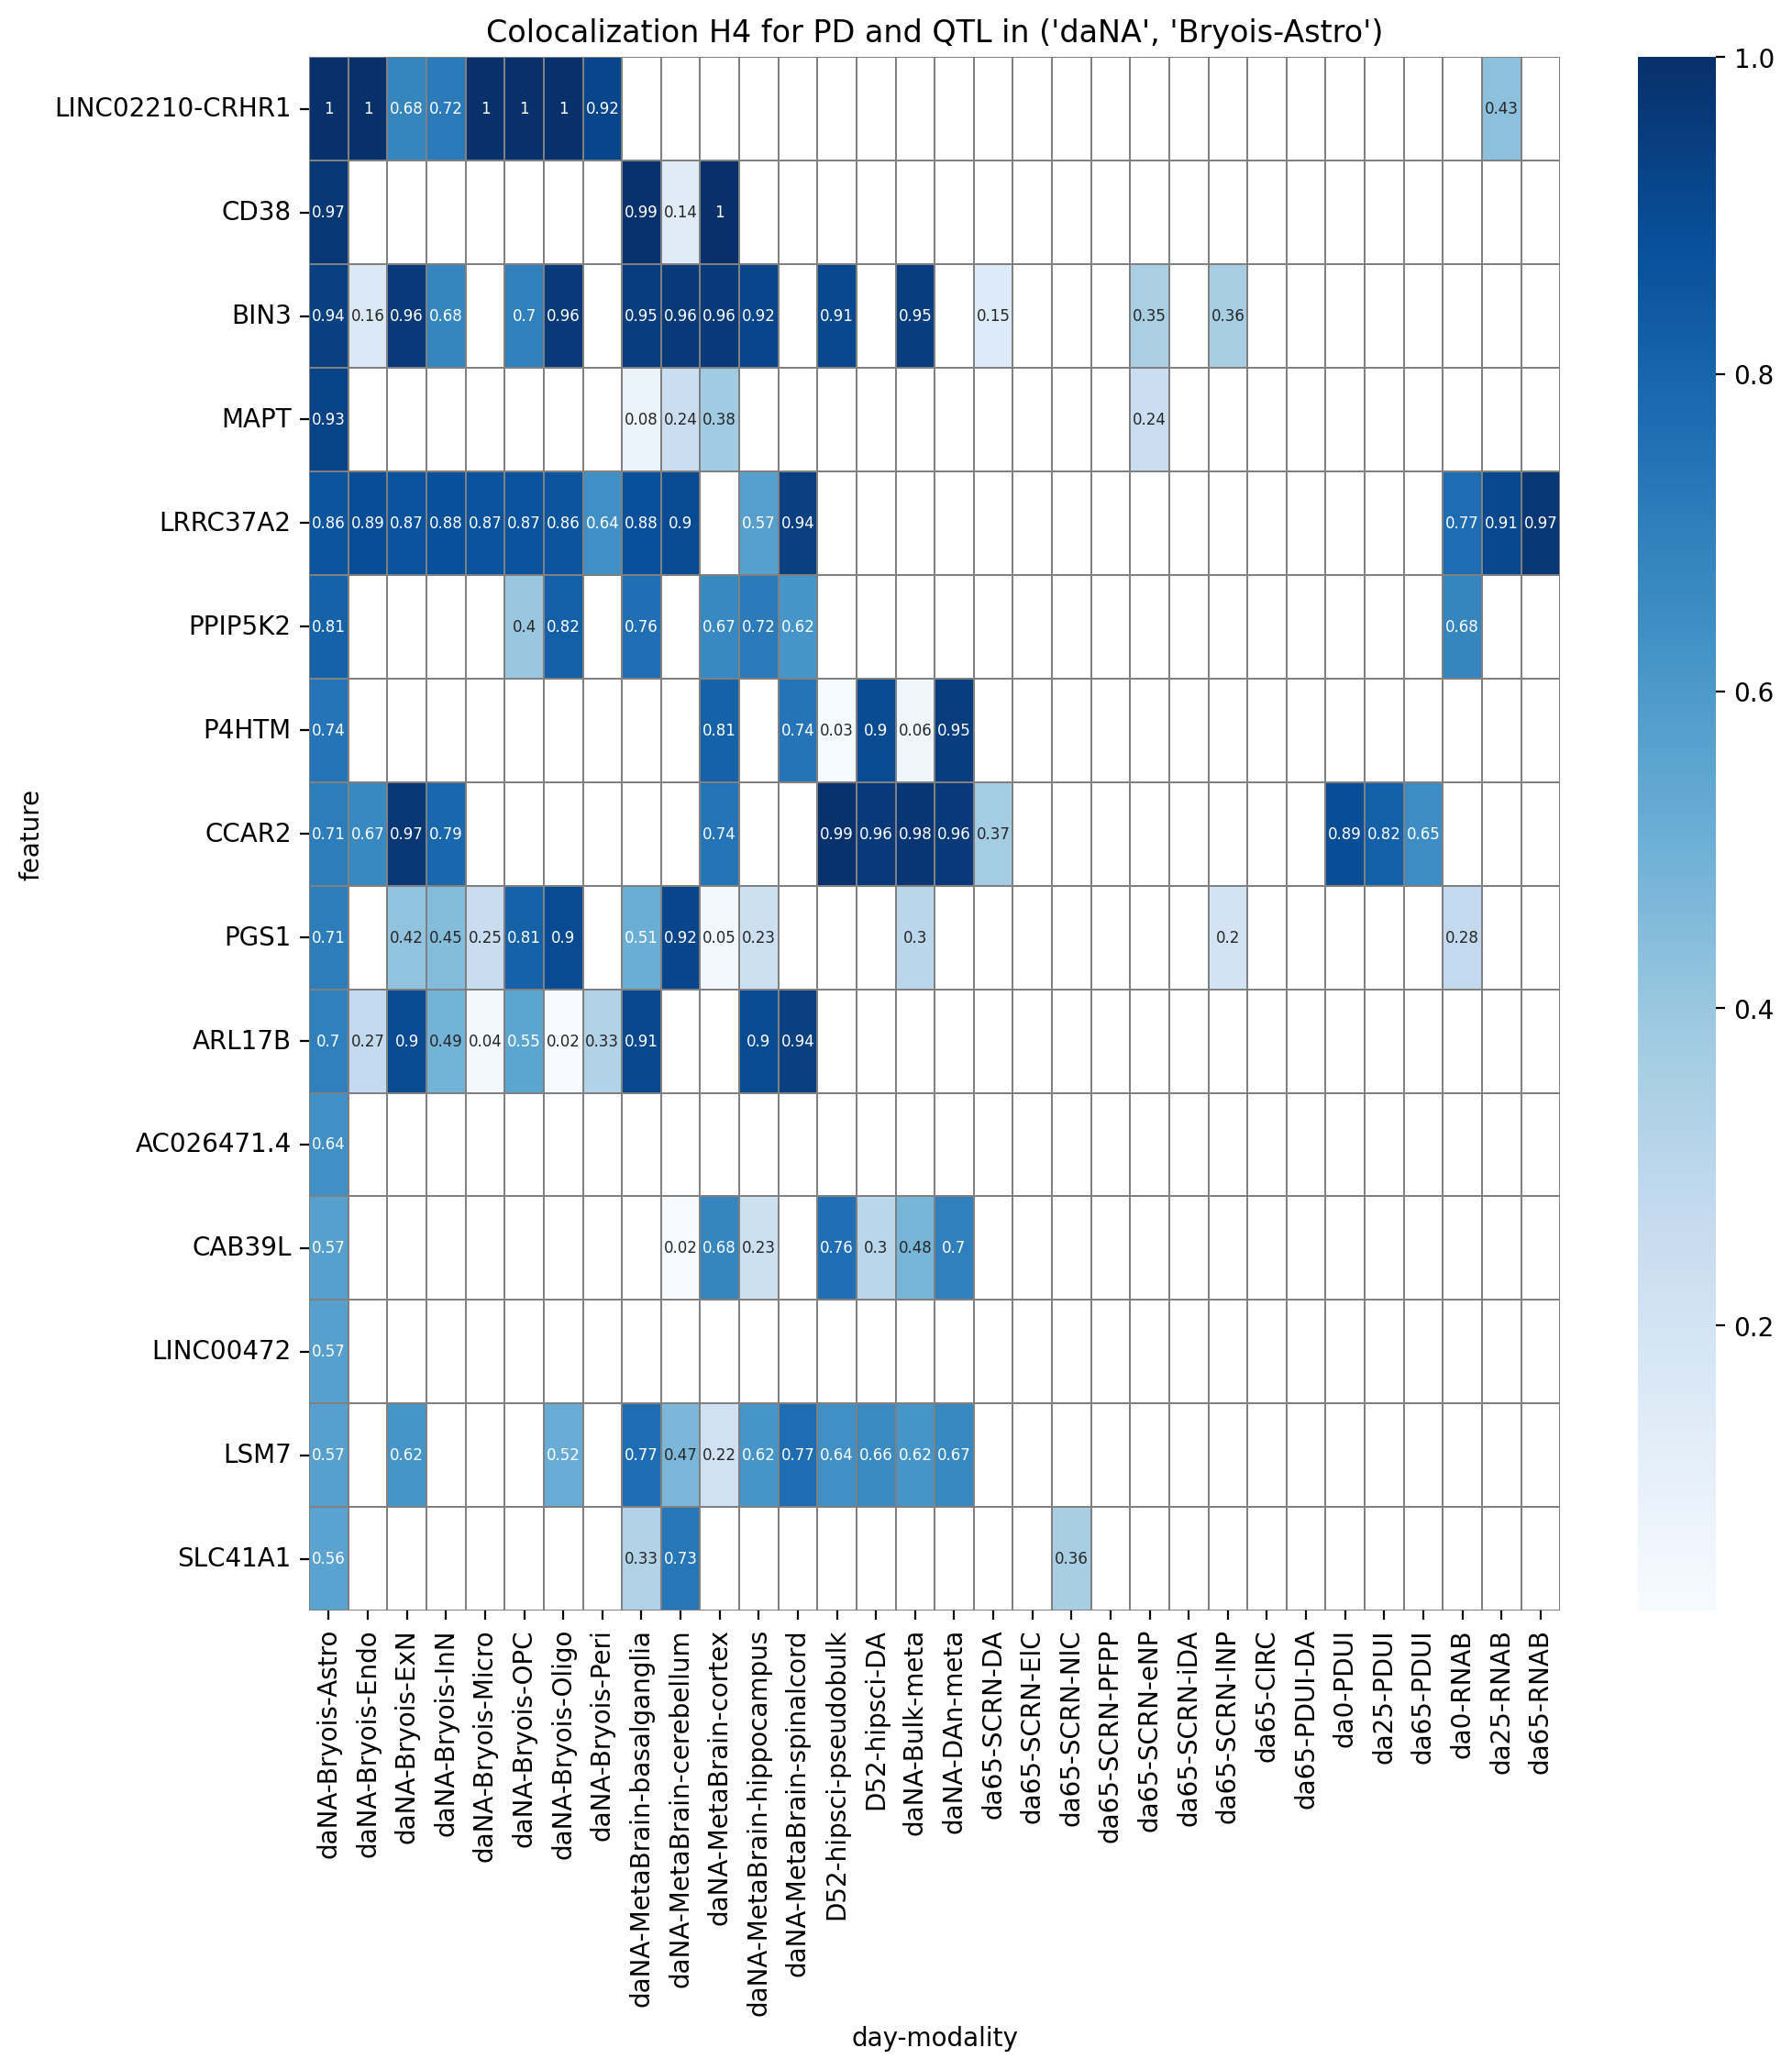

Bryois-Oligo
(18, 32)


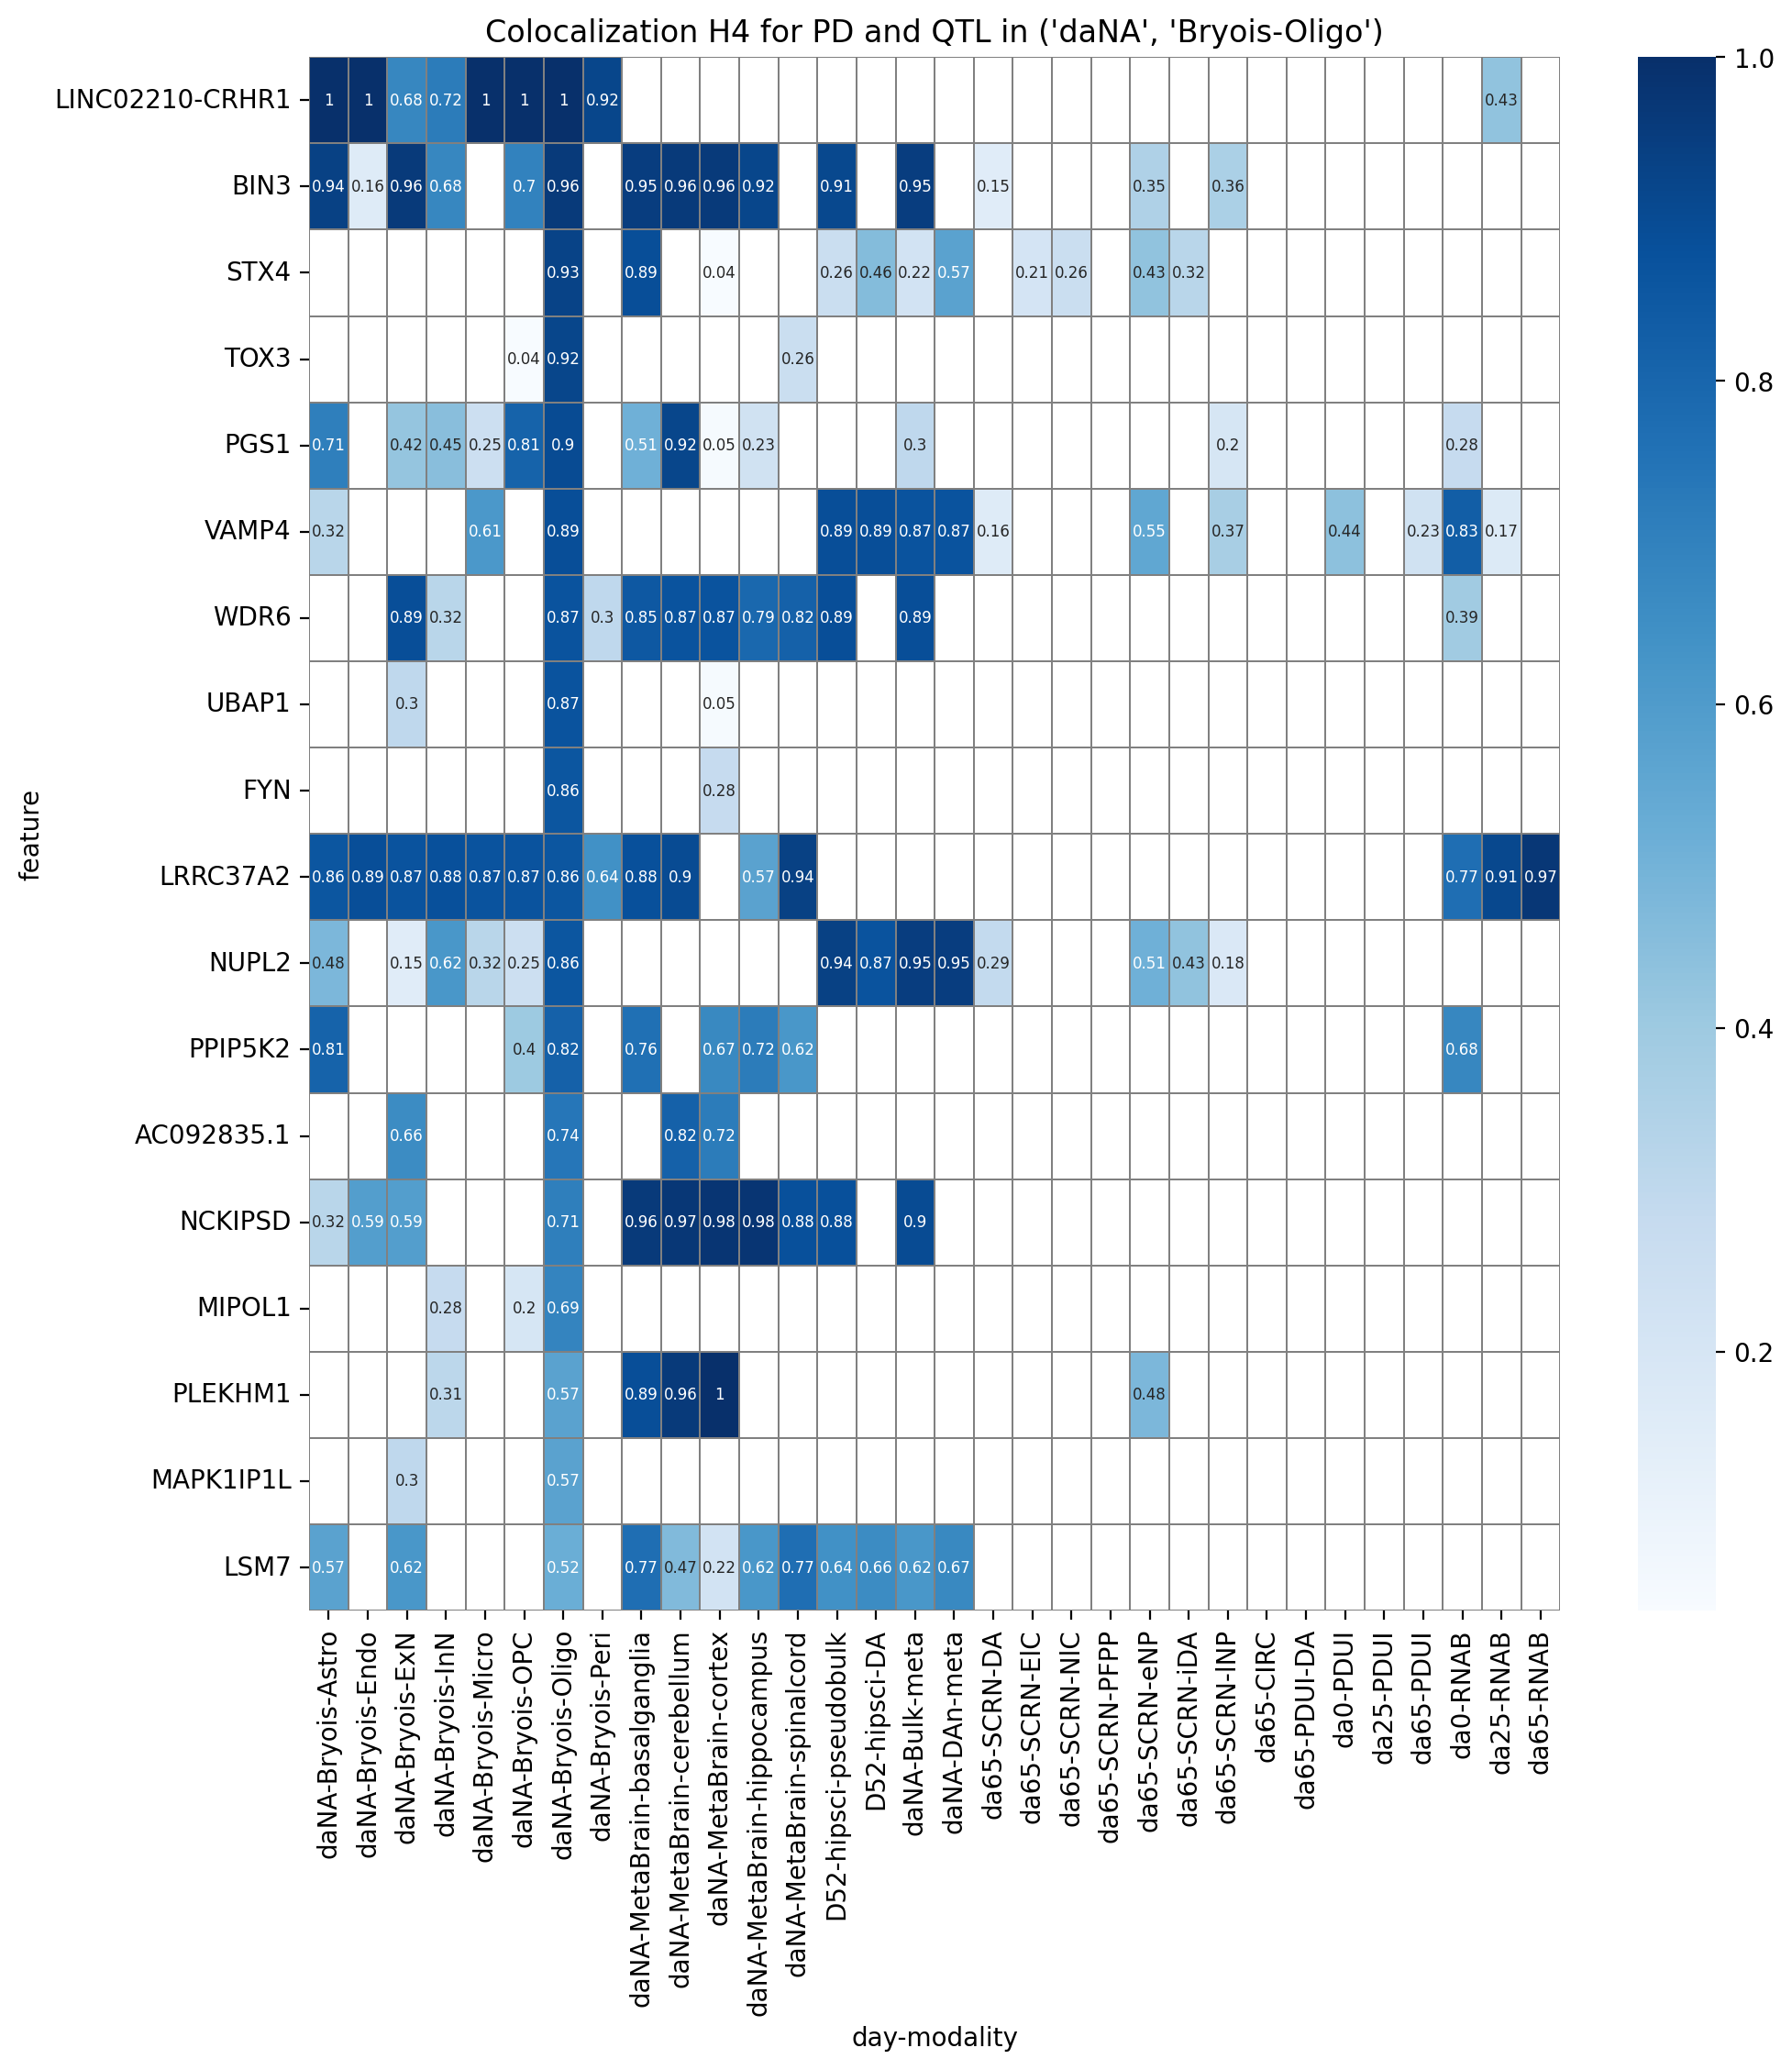

In [17]:
oi_modalities = [('daNA', 'DAn-meta'), ('daNA', 'Bulk-meta'), 
                 ('da65', 'PDUI'), ('da65', 'PDUI-DA'),
                 ('daNA', 'Bryois-ExN'), ('daNA', 'Bryois-InN'), 
                 ('daNA', 'Bryois-Micro'), ('daNA', 'Bryois-Astro'), 
                 ('daNA', 'Bryois-Oligo')]
for modality in oi_modalities:
    print(modality[1])
    temp_df = wcoloc_df.loc[wcoloc_df[modality] > min_h4].sort_values(modality, ascending=False)
    # sort by foundin DA neuron results
    temp_df = temp_df.sort_values(by=[modality], ascending=False)
    print(f'{temp_df.shape}')
    sub_figure_file = f'{figures_dir}/{cohort}.colocalization.{dx}.{modality[1]}.png'
    with rc_context({'figure.figsize': (11, 11), 'figure.dpi': dpi_value}):
        plt.style.use('seaborn-bright')    
        heatmap(temp_df, annot=True, linecolor='grey',
                annot_kws={"fontsize":6}, linewidths=0.05, cmap='Blues')
        plt.yticks(rotation=0)
        plt.title(f'Colocalization H4 for {dx} and QTL in {modality}')
        plt.savefig(sub_figure_file, dpi=dpi_value, bbox_inches='tight', 
                    transparent=True, pad_inches=1)
        plt.show()    

In [18]:
temp_df.head()

day                     daNA                                                 \
modality        Bryois-Astro Bryois-Endo Bryois-ExN Bryois-InN Bryois-Micro   
feature                                                                       
LINC02210-CRHR1         1.00        1.00       0.68       0.72         1.00   
BIN3                    0.94        0.16       0.96       0.68          NaN   
STX4                     NaN         NaN        NaN        NaN          NaN   
TOX3                     NaN         NaN        NaN        NaN          NaN   
PGS1                    0.71         NaN       0.42       0.45         0.25   

day                                                                         \
modality        Bryois-OPC Bryois-Oligo Bryois-Peri MetaBrain-basalganglia   
feature                                                                      
LINC02210-CRHR1       1.00         1.00        0.92                    NaN   
BIN3                  0.70         0.96         NaN                   0.95   
STX4                   NaN         0.93         NaN                   0.89   
TOX3                  0.04         0.92         NaN                    NaN   
PGS1                  0.81         0.90         NaN                   0.51   

day                                   ...     da65                        da0  \
modality        MetaBrain-cerebellum  ... SCRN-iDA SCRN-lNP CIRC PDUI-DA PDUI   
feature                               ...                                       
LINC02210-CRHR1                  NaN  ...      NaN      NaN  NaN     NaN  NaN   
BIN3                            0.96  ...      NaN     0.36  NaN     NaN  NaN   
STX4                             NaN  ...     0.32      NaN  NaN     NaN  NaN   
TOX3                             NaN  ...      NaN      NaN  NaN     NaN  NaN   
PGS1                            0.92  ...      NaN     0.20  NaN     NaN  NaN   

day             da25 da65   da0  da25 da65  
modality        PDUI PDUI  RNAB  RNAB RNAB  
feature                                     
LINC02210-CRHR1  NaN  NaN   NaN  0.43  NaN  
BIN3             NaN  NaN   NaN   NaN  NaN  
STX4             NaN  NaN   NaN   NaN  NaN  
TOX3             NaN  NaN   NaN   NaN  NaN  
PGS1             NaN  NaN  0.28   NaN  NaN  

[5 rows x 32 columns]

### print features with above threshold H4 by modalities of interest

In [19]:
oi_modalities = [('daNA', 'DAn-meta'), ('daNA', 'Bulk-meta'), 
                 ('da65', 'PDUI'), ('da65', 'PDUI-DA'),
                 ('daNA', 'Bryois-ExN'), ('daNA', 'Bryois-InN'), 
                 ('daNA', 'Bryois-Micro'), ('daNA', 'Bryois-Astro'), 
                 ('daNA', 'Bryois-Oligo'), ('daNA', 'MetaBrain-basalganglia'), 
              ('daNA', 'MetaBrain-cerebellum'), ('daNA', 'MetaBrain-cortex'), 
              ('daNA', 'MetaBrain-hippocampus'), ('daNA', 'MetaBrain-spinalcord'), 
                 ('D52', 'hipsci-DA'), ('D52', 'hipsci-pseudobulk')]
for modality in oi_modalities:
    print(modality)
    temp = wcoloc_df.loc[wcoloc_df[modality] > min_h4].sort_values(modality, ascending=False)
    print(temp.index)
    display(temp[modality])

('daNA', 'DAn-meta')
Index(['CCAR2', 'NUPL2', 'P4HTM', 'RNF141', 'SH3GL2', 'CTSB', 'KANSL1',
       'STX1B', 'VAMP4', 'GRN', 'GCH1', 'CAB39L', 'LSM7', 'SH2B1', 'STX4'],
      dtype='object', name='feature')


feature
CCAR2     0.96
NUPL2     0.95
P4HTM     0.95
RNF141    0.94
SH3GL2    0.93
CTSB      0.92
KANSL1    0.92
STX1B     0.89
VAMP4     0.87
GRN       0.84
GCH1      0.73
CAB39L    0.70
LSM7      0.67
SH2B1     0.60
STX4      0.57
Name: (daNA, DAn-meta), dtype: float64

('daNA', 'Bulk-meta')
Index(['CCAR2', 'BIN3', 'NUPL2', 'CTSB', 'KANSL1', 'NCKIPSD', 'WDR6', 'RNF141',
       'VAMP4', 'CHRNB1', 'ZNF668', 'RAB29', 'KLHL7', 'NUCKS1', 'LGALS3',
       'LSM7', 'STK39', 'SULT1A1', 'FBRSL1'],
      dtype='object', name='feature')


feature
CCAR2      0.98
BIN3       0.95
NUPL2      0.95
CTSB       0.93
KANSL1     0.92
NCKIPSD    0.90
WDR6       0.89
RNF141     0.88
VAMP4      0.87
CHRNB1     0.83
ZNF668     0.77
RAB29      0.72
KLHL7      0.67
NUCKS1     0.66
LGALS3     0.64
LSM7       0.62
STK39      0.60
SULT1A1    0.54
FBRSL1     0.52
Name: (daNA, Bulk-meta), dtype: float64

('da65', 'PDUI')
Index(['lnc-RPRML-3', 'CLCN3:chr4:169719907-169720545', 'CTSB', 'CCAR2'], dtype='object', name='feature')


feature
lnc-RPRML-3                       0.81
CLCN3:chr4:169719907-169720545    0.70
CTSB                              0.68
CCAR2                             0.65
Name: (da65, PDUI), dtype: float64

('da65', 'PDUI-DA')
Index(['UFC1:chr1:161158412-161158682'], dtype='object', name='feature')


feature
UFC1:chr1:161158412-161158682    0.54
Name: (da65, PDUI-DA), dtype: float64

('daNA', 'Bryois-ExN')
Index(['CCAR2', 'BIN3', 'LINC01630', 'ARL17B', 'WDR6', 'LRRC37A2', 'SLC25A21',
       'KANSL1', 'USO1', 'SPTSSB', 'LINC02210-CRHR1', 'SH3GL2', 'AC092835.1',
       'LSM7', 'SH2B1', 'NCKIPSD', 'TUFM', 'GPRC5B'],
      dtype='object', name='feature')


feature
CCAR2              0.97
BIN3               0.96
LINC01630          0.96
ARL17B             0.90
WDR6               0.89
LRRC37A2           0.87
SLC25A21           0.80
KANSL1             0.78
USO1               0.72
SPTSSB             0.70
LINC02210-CRHR1    0.68
SH3GL2             0.66
AC092835.1         0.66
LSM7               0.62
SH2B1              0.61
NCKIPSD            0.59
TUFM               0.58
GPRC5B             0.56
Name: (daNA, Bryois-ExN), dtype: float64

('daNA', 'Bryois-InN')
Index(['LRRC37A2', 'CCAR2', 'KANSL1', 'LINC02210-CRHR1', 'BIN3', 'SH2B1',
       'TUFM', 'NUPL2', 'CHFR'],
      dtype='object', name='feature')


feature
LRRC37A2           0.88
CCAR2              0.79
KANSL1             0.74
LINC02210-CRHR1    0.72
BIN3               0.68
SH2B1              0.66
TUFM               0.65
NUPL2              0.62
CHFR               0.56
Name: (daNA, Bryois-InN), dtype: float64

('daNA', 'Bryois-Micro')
Index(['LINC02210-CRHR1', 'TMEM163', 'GPNMB', 'LRRC37A2', 'P2RY12', 'MED12L',
       'DNM3', 'VAMP4', 'MED13', 'ZCCHC8', 'LRRK2'],
      dtype='object', name='feature')


feature
LINC02210-CRHR1    1.00
TMEM163            0.97
GPNMB              0.94
LRRC37A2           0.87
P2RY12             0.79
MED12L             0.67
DNM3               0.63
VAMP4              0.61
MED13              0.60
ZCCHC8             0.55
LRRK2              0.51
Name: (daNA, Bryois-Micro), dtype: float64

('daNA', 'Bryois-Astro')
Index(['LINC02210-CRHR1', 'CD38', 'BIN3', 'MAPT', 'LRRC37A2', 'PPIP5K2',
       'P4HTM', 'CCAR2', 'PGS1', 'ARL17B', 'AC026471.4', 'CAB39L', 'LINC00472',
       'LSM7', 'SLC41A1'],
      dtype='object', name='feature')


feature
LINC02210-CRHR1    1.00
CD38               0.97
BIN3               0.94
MAPT               0.93
LRRC37A2           0.86
PPIP5K2            0.81
P4HTM              0.74
CCAR2              0.71
PGS1               0.71
ARL17B             0.70
AC026471.4         0.64
CAB39L             0.57
LINC00472          0.57
LSM7               0.57
SLC41A1            0.56
Name: (daNA, Bryois-Astro), dtype: float64

('daNA', 'Bryois-Oligo')
Index(['LINC02210-CRHR1', 'BIN3', 'STX4', 'TOX3', 'PGS1', 'VAMP4', 'WDR6',
       'UBAP1', 'NUPL2', 'LRRC37A2', 'FYN', 'PPIP5K2', 'AC092835.1', 'NCKIPSD',
       'MIPOL1', 'PLEKHM1', 'MAPK1IP1L', 'LSM7'],
      dtype='object', name='feature')


feature
LINC02210-CRHR1    1.00
BIN3               0.96
STX4               0.93
TOX3               0.92
PGS1               0.90
VAMP4              0.89
WDR6               0.87
UBAP1              0.87
NUPL2              0.86
LRRC37A2           0.86
FYN                0.86
PPIP5K2            0.82
AC092835.1         0.74
NCKIPSD            0.71
MIPOL1             0.69
PLEKHM1            0.57
MAPK1IP1L          0.57
LSM7               0.52
Name: (daNA, Bryois-Oligo), dtype: float64

('daNA', 'MetaBrain-basalganglia')
Index(['CD38', 'NUP42', 'NCKIPSD', 'ARL17A', 'BIN3', 'GPNMB', 'RAB29',
       'ARL17B', 'ITGA8', 'KANSL1', 'RPP21', 'STX4', 'PLEKHM1', 'LRRC37A2',
       'WDR6', 'LSM7', 'PPIP5K2', 'SBNO1', 'PROM2', 'MAP3K14', 'CHRNB1',
       'LRRC37A', 'EIF3C', 'DCAF12', 'PRSS3', 'TUFM', 'PGS1', 'LAT'],
      dtype='object', name='feature')


feature
CD38        0.99
NUP42       0.96
NCKIPSD     0.96
ARL17A      0.95
BIN3        0.95
GPNMB       0.95
RAB29       0.94
ARL17B      0.91
ITGA8       0.91
KANSL1      0.91
RPP21       0.90
STX4        0.89
PLEKHM1     0.89
LRRC37A2    0.88
WDR6        0.85
LSM7        0.77
PPIP5K2     0.76
SBNO1       0.76
PROM2       0.74
MAP3K14     0.70
CHRNB1      0.68
LRRC37A     0.66
EIF3C       0.62
DCAF12      0.62
PRSS3       0.58
TUFM        0.56
PGS1        0.51
LAT         0.51
Name: (daNA, MetaBrain-basalganglia), dtype: float64

('daNA', 'MetaBrain-cerebellum')
Index(['SNCA', 'FMNL1', 'HIP1R', 'RAB29', 'CHRNB1', 'RETREG3', 'NCKIPSD',
       'PLEKHM1', 'BIN3', 'CTSB', 'LAT', 'GPNMB', 'UBE2R2', 'DNAH17',
       'PSMC3IP', 'SETD1A', 'PGS1', 'SUCNR1', 'LRRC37A2', 'ARL17A', 'DYRK1A',
       'STX1B', 'KCNIP3', 'WDR6', 'ZKSCAN8', 'NICN1', 'AC092835.1', 'STARD7',
       'RPP21', 'GIN1', 'SLC41A1', 'ZSCAN9', 'DGKQ', 'STH', 'SLC35G6', 'SYT17',
       'ATP2A1', 'TUFM', 'SH2B1', 'CRHR1', 'P2RY12', 'MCCC1', 'SPPL2C',
       'MEX3C', 'KLHDC8B'],
      dtype='object', name='feature')


feature
SNCA          1.00
FMNL1         1.00
HIP1R         1.00
RAB29         1.00
CHRNB1        0.99
RETREG3       0.98
NCKIPSD       0.97
PLEKHM1       0.96
BIN3          0.96
CTSB          0.96
LAT           0.95
GPNMB         0.94
UBE2R2        0.94
DNAH17        0.93
PSMC3IP       0.92
SETD1A        0.92
PGS1          0.92
SUCNR1        0.92
LRRC37A2      0.90
ARL17A        0.90
DYRK1A        0.90
STX1B         0.89
KCNIP3        0.88
WDR6          0.87
ZKSCAN8       0.86
NICN1         0.84
AC092835.1    0.82
STARD7        0.81
RPP21         0.80
GIN1          0.77
SLC41A1       0.73
ZSCAN9        0.72
DGKQ          0.72
STH           0.71
SLC35G6       0.68
SYT17         0.66
ATP2A1        0.66
TUFM          0.64
SH2B1         0.63
CRHR1         0.63
P2RY12        0.62
MCCC1         0.60
SPPL2C        0.59
MEX3C         0.57
KLHDC8B       0.57
Name: (daNA, MetaBrain-cerebellum), dtype: float64

('daNA', 'MetaBrain-cortex')
Index(['PLEKHM1', 'RAB29', 'SYT17', 'CD38', 'LAT', 'CHRNB1', 'NCKIPSD', 'CTSB',
       'HIST1H4J', 'DYRK1A', 'RETREG3', 'SPTSSB', 'FGFBP2', 'HSD3B7', 'UBE2R2',
       'P2RY12', 'C8orf58', 'BIN3', 'UBAP2', 'EIF3C', 'CYLD', 'MEX3C',
       'MED12L', 'SETD1A', 'MED13', 'KCNIP3', 'PAM', 'ARL17A', 'RABEP2',
       'WDR6', 'ARIH2', 'GPNMB', 'DALRD3', 'STH', 'P4HTM', 'SCAF11', 'NDUFAF3',
       'CCAR2', 'SPPL2C', 'AC092835.1', 'CRHR1', 'DNAH17', 'CAB39L', 'EIF3CL',
       'FOXA1', 'NFATC2IP', 'PPIP5K2', 'QARS', 'RPP21', 'KANSL1', 'GIN1',
       'TPST1', 'GUSB', 'AC007906.2', 'FMNL1'],
      dtype='object', name='feature')


feature
PLEKHM1       1.00
RAB29         1.00
SYT17         1.00
CD38          1.00
LAT           0.99
CHRNB1        0.99
NCKIPSD       0.98
CTSB          0.97
HIST1H4J      0.97
DYRK1A        0.97
RETREG3       0.97
SPTSSB        0.97
FGFBP2        0.96
HSD3B7        0.96
UBE2R2        0.96
P2RY12        0.96
C8orf58       0.96
BIN3          0.96
UBAP2         0.96
EIF3C         0.94
CYLD          0.94
MEX3C         0.94
MED12L        0.92
SETD1A        0.91
MED13         0.91
KCNIP3        0.91
PAM           0.89
ARL17A        0.89
RABEP2        0.88
WDR6          0.87
ARIH2         0.87
GPNMB         0.87
DALRD3        0.87
STH           0.83
P4HTM         0.81
SCAF11        0.81
NDUFAF3       0.80
CCAR2         0.74
SPPL2C        0.74
AC092835.1    0.72
CRHR1         0.72
DNAH17        0.70
CAB39L        0.68
EIF3CL        0.68
FOXA1         0.68
NFATC2IP      0.68
PPIP5K2       0.67
QARS          0.66
RPP21         0.63
KANSL1        0.62
GIN1          0.60
TPST1         0.55
GUSB

('daNA', 'MetaBrain-hippocampus')
Index(['NCKIPSD', 'BIN3', 'ARL17A', 'ARL17B', 'KANSL1', 'GPNMB', 'EIF3C',
       'NUP42', 'WDR6', 'PPIP5K2', 'C8orf58', 'PROM2', 'GIN1', 'LSM7', 'TUBG2',
       'RNF141', 'DCAF12', 'LRRC37A2', 'RAB29'],
      dtype='object', name='feature')


feature
NCKIPSD     0.98
BIN3        0.92
ARL17A      0.91
ARL17B      0.90
KANSL1      0.88
GPNMB       0.88
EIF3C       0.85
NUP42       0.80
WDR6        0.79
PPIP5K2     0.72
C8orf58     0.71
PROM2       0.66
GIN1        0.64
LSM7        0.62
TUBG2       0.62
RNF141      0.60
DCAF12      0.58
LRRC37A2    0.57
RAB29       0.56
Name: (daNA, MetaBrain-hippocampus), dtype: float64

('daNA', 'MetaBrain-spinalcord')
Index(['LRRC37A', 'ARL17B', 'LRRC37A2', 'NCKIPSD', 'WDR6', 'LSM7', 'KANSL1',
       'P4HTM', 'PPIP5K2', 'EIF3C', 'NEUROG2'],
      dtype='object', name='feature')


feature
LRRC37A     0.99
ARL17B      0.94
LRRC37A2    0.94
NCKIPSD     0.88
WDR6        0.82
LSM7        0.77
KANSL1      0.76
P4HTM       0.74
PPIP5K2     0.62
EIF3C       0.56
NEUROG2     0.53
Name: (daNA, MetaBrain-spinalcord), dtype: float64

('D52', 'hipsci-DA')
Index(['ENSG00000214401', 'MAPT-AS1', 'CCAR2', 'STX1B', 'RNF141', 'CTSB',
       'KANSL1', 'P4HTM', 'VAMP4', 'NUPL2', 'SH3GL2', 'PRSS3', 'GRN', 'LSM7',
       'SH2B1', 'CRHR1'],
      dtype='object', name='feature')


feature
ENSG00000214401    1.00
MAPT-AS1           1.00
CCAR2              0.96
STX1B              0.96
RNF141             0.95
CTSB               0.91
KANSL1             0.90
P4HTM              0.90
VAMP4              0.89
NUPL2              0.87
SH3GL2             0.84
PRSS3              0.69
GRN                0.66
LSM7               0.66
SH2B1              0.59
CRHR1              0.54
Name: (D52, hipsci-DA), dtype: float64

('D52', 'hipsci-pseudobulk')
Index(['ENSG00000214401', 'CCAR2', 'RNF141', 'SULT1A1', 'NUPL2', 'CTSB',
       'BIN3', 'CHRNB1', 'ZNF668', 'KANSL1', 'VAMP4', 'WDR6', 'NCKIPSD',
       'RAB29', 'CAB39L', 'KLHL7', 'CRCP', 'LSM7', 'SH2B1', 'CRLS1', 'LGALS3',
       'STK39', 'TUFM', 'PSMC3IP'],
      dtype='object', name='feature')


feature
ENSG00000214401    1.00
CCAR2              0.99
RNF141             0.98
SULT1A1            0.96
NUPL2              0.94
CTSB               0.92
BIN3               0.91
CHRNB1             0.91
ZNF668             0.90
KANSL1             0.90
VAMP4              0.89
WDR6               0.89
NCKIPSD            0.88
RAB29              0.84
CAB39L             0.76
KLHL7              0.74
CRCP               0.73
LSM7               0.64
SH2B1              0.63
CRLS1              0.59
LGALS3             0.57
STK39              0.56
TUFM               0.55
PSMC3IP            0.52
Name: (D52, hipsci-pseudobulk), dtype: float64

In [20]:
!date

Thu Oct 12 20:57:20 UTC 2023
